In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
%%capture
!pip install pydna
!pip install pandas
!pip install --upgrade xlrd
!pip install constrain

# 10_2_TEST_Library_characterization

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/ConStrain/blob/main/colab_notebooks/10_2_TEST_Library_Characterization.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# 0. Overview

In this notebook we continue the workflow by analyzing the second combinatorial library.  To do so, we use determine strictosidine levels through massspectrometry of the generated strains from the previously generated library [09_2_BUILD_CombinatorialLibrary](../colab_notebooks/09_2_BUILD_CombinatorialLibrary.ipynb) and genotype the strains by sanger sequencing to determine promoter:gene combinations. This workflow is essentially the same as we saw in notebook [06_1_TEST_LibraryCharacterisation](../colab_notebooks/06_1_TEST_LibraryCharacterisation.ipynb).  

## Project overview - Phenotyping:Genotyping the combinatorial library. 

**Hypothesis**
1. Specific combinations of CPR / G8H homologs and corresponding expression levels can remove the G8H bottleneck in the Strictosidine pathway

Aim: To test the hypothesis

Tasks
1. dgRNA
2. Base strain
3. Library
**4. Phenotyping/Genotyping**
   - Phenotyping : Data wrangling of LC-MS data
   - Genotyping : Sanger sequencing
   - Plotting the results
5. Machine Learning


# 1. DATA wrangling

In [3]:
# Lets read in plate 53 and 54

plate53 = pd.read_csv("ConStrain_on_google_colab/data/07-lcms/raw/lcms_data/lc0005.csv", sep = ',')
plate54 = pd.read_csv("ConStrain_on_google_colab/data/07-lcms/raw/lcms_data/lc0006.csv", sep = ',')


# Stack the DataFrames on top of each other
unprocessed_lcms_results = pd.concat([ plate53, plate54 ], axis=0)
unprocessed_lcms_results.head()

,data_file,sample_notes,Amt_ug_L_Loganin,Amt_ug_L_Secologanin,Amt_ug_L_Strictosidine,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine
0,210927_TMET576_016.xms,96WP1232_A1,NaN,NaN,1351.268,180064.781,NaN,NaN,2.546823,1123.859574
1,210927_TMET576_017.xms,96WP1232_A2,NaN,NaN,4203.014,146340.297,NaN,NaN,7.921696,913.370971
2,210927_TMET576_018.xms,96WP1232_A3,NaN,NaN,NaN,144634.984,NaN,NaN,NaN,902.727400
3,210927_TMET576_019.xms,96WP1232_A4,586.062,NaN,11989.688,131989.250,1.501260,NaN,22.597750,823.800087
4,210927_TMET576_020.xms,96WP1232_A5,1812.931,NaN,17870.656,130796.781,4.644016,NaN,33.681995,816.357390


In [4]:
# filtering out all columns that that have Nan in all of the following columns: 'Amt_uM_Loganin', 'Amt_uM_Secologanin','Amt_uM_Strictosidine', 'Amt_uM_Tryptamine'
df_filter = unprocessed_lcms_results.dropna(subset=[ 'Amt_uM_Loganin', 'Amt_uM_Secologanin','Amt_uM_Strictosidine', 'Amt_uM_Tryptamine' ],  how='all')

# replacing N.D and N.A. with NaN
df_filter = df_filter.replace('N.D.', np.NaN)
df_filter = df_filter.replace('N.A.', np.NaN)

# Excel contains values both in ug and uM. I'll use uM because values are in a better scale.
# remove cols starting with "Amt_ug_L_" because of redundancy and uM has better scale.
df_filter.drop(df_filter.iloc[:, 2:5], inplace = True, axis = 1)
df_filter

#df_filter
## saving the column names
list_of_coloumn_names = df_filter.columns.values.tolist()
#
## split the sample notes column
df_filter_plates = df_filter['sample_notes'].str.split('_', expand=True)
df_filter_plates = df_filter_plates[[0,1]]
df_filter_plates.columns = ['plate', 'well']
list_of_coloumn_names_2 = df_filter_plates.columns.values.tolist()
#
## Add the to dataframes together
concatenated = pd.concat([df_filter, df_filter_plates], axis=1, ignore_index=True)
concatenated.columns = list_of_coloumn_names + list_of_coloumn_names_2

##add 0 to all nan positions 
concatenated = concatenated.fillna(0)


### Changing the names of the plates to yp53/54
concatenated.loc[concatenated['plate'] == '96WP1232', 'plate'] = 'yp53'
concatenated.loc[concatenated['plate'] == '96WP1248', 'plate'] = 'yp54'

# Change name
lcms_results = concatenated
lcms_results.head()

,data_file,sample_notes,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,plate,well
0,210927_TMET576_016.xms,96WP1232_A1,180064.781,0.000000,0.0,2.546823,1123.859574,yp53,A1
1,210927_TMET576_017.xms,96WP1232_A2,146340.297,0.000000,0.0,7.921696,913.370971,yp53,A2
2,210927_TMET576_018.xms,96WP1232_A3,144634.984,0.000000,0.0,0.000000,902.727400,yp53,A3
3,210927_TMET576_019.xms,96WP1232_A4,131989.250,1.501260,0.0,22.597750,823.800087,yp53,A4
4,210927_TMET576_020.xms,96WP1232_A5,130796.781,4.644016,0.0,33.681995,816.357390,yp53,A5


In [5]:
## changing the well names to incorporate a 0 between the first wells

In [6]:
well_list = lcms_results['well'].to_list()

new_well_list = []
for i in range(len(well_list)): 
    if len(well_list[i]) == 2:
        
        well = str(well_list[i][0:1])+'0'+str(well_list[i][1:2])
        new_well_list.append(well)
        well= ''
        
    else: 
        new_well_list.append(well_list[i])

lcms_results['well'] = new_well_list

## 1.1 Merge Plate design with yp53-54 metadata into single csv file


In [7]:
# importing xls file
xls = pd.ExcelFile('ConStrain_on_google_colab/data/07-lcms/raw/plate_design/plateDesign_yp53-54_MIA-HA-111-145.xlsx')

# reading the different sheets
df1 = pd.read_excel(xls, 'yp53_reallocated')  # plate 53
df1["plate"] = 'yp53' 

df2 = pd.read_excel(xls, '111-115_121-125_136-140-145yp54') # plate 54
df2["plate"] = 'yp54' 


# fixing the re-located samples
#df1['position'] = df1['old position']

In [8]:
results_merged = pd.concat([df1, df2], ignore_index=True)

In [9]:
results_merged.head()

,position,Sample name,Cellular compartment,Medium,Sample Type,Temperature (C),Timepoint (h),Cultivation Container ID/Position,Operator Name,Replicate #,Strain,Genotype,Date of sampling,old position,plate,Unnamed: 12
0,A01,20210922MIA-HA-116_1,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,1.0,MIA-HA-116,VminG8H AanCPR,20210922.0,A01,yp53,NaN
1,A02,20210922MIA-HA-116_2,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,2.0,MIA-HA-116,VminG8H AanCPR,20210922.0,A02,yp53,NaN
2,A03,20210922MIA-HA-116_3,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,3.0,MIA-HA-116,VminG8H AanCPR,20210922.0,A03,yp53,NaN
3,A04,20210922MIA-HA-116_4,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,4.0,MIA-HA-116,VminG8H AanCPR,20210922.0,A04,yp53,NaN
4,A05,20210922MIA-HA-117_1,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,1.0,MIA-HA-117,SmusG8H AanCPR,20210922.0,A05,yp53,NaN


At this point there are a lot of empty rows that will be deleted later in the process. 

In [10]:
results_merged.to_csv('ConStrain_on_google_colab/data/07-lcms/processed/plate_design/plate_design_yp53-54_merged.csv', header = True, index = False)

In [11]:
# read into a dataframe
PlateDesign = pd.read_csv('ConStrain_on_google_colab/data/07-lcms/processed/plate_design/plate_design_yp53-54_merged.csv') 
PlateDesign.head()

,position,Sample name,Cellular compartment,Medium,Sample Type,Temperature (C),Timepoint (h),Cultivation Container ID/Position,Operator Name,Replicate #,Strain,Genotype,Date of sampling,old position,plate,Unnamed: 12
0,A01,20210922MIA-HA-116_1,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,1.0,MIA-HA-116,VminG8H AanCPR,20210922.0,A01,yp53,NaN
1,A02,20210922MIA-HA-116_2,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,2.0,MIA-HA-116,VminG8H AanCPR,20210922.0,A02,yp53,NaN
2,A03,20210922MIA-HA-116_3,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,3.0,MIA-HA-116,VminG8H AanCPR,20210922.0,A03,yp53,NaN
3,A04,20210922MIA-HA-116_4,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,4.0,MIA-HA-116,VminG8H AanCPR,20210922.0,A04,yp53,NaN
4,A05,20210922MIA-HA-117_1,Extracellular Region,YPD,Specimen,30.0,144.0,NaN,Christine Møller Pedersen,1.0,MIA-HA-117,SmusG8H AanCPR,20210922.0,A05,yp53,NaN


In [12]:
# we take the columns that we are interested in
PlateDesign= PlateDesign[['plate','position','Strain', 'Replicate #', 'Genotype', 'Medium']]
# rename them
PlateDesign.columns = ['plate', 'well', 'strain','col_no', 'genotype', 'medium']
PlateDesign.head()

,plate,well,strain,col_no,genotype,medium
0,yp53,A01,MIA-HA-116,1.0,VminG8H AanCPR,YPD
1,yp53,A02,MIA-HA-116,2.0,VminG8H AanCPR,YPD
2,yp53,A03,MIA-HA-116,3.0,VminG8H AanCPR,YPD
3,yp53,A04,MIA-HA-116,4.0,VminG8H AanCPR,YPD
4,yp53,A05,MIA-HA-117,1.0,SmusG8H AanCPR,YPD


In [13]:
# Merge our lcms file with the genotype/strain 
lcms_platedesign = pd.merge(lcms_results, PlateDesign, left_on=['plate','well'], right_on = ['plate','well'])

Note: the first row in the datafile "Result_table_211001_tmet581_yp54.csv" is a data artifact that doesnt belong to our analysis i.g it doesnt have the right plate number in the sample notes i.e : "211001_TMET581_002.xms". Therefore we loose a row here compared to the csv file. 

## 1.2 YP53+54

*** Experiment
1. Check if MIA-HA-x strains produces MIA's 

Strains  
1. YP53

Media feed: 0.2 mM geraniol & 1 mM tryptamine
1. YP + 2 % glucose + feed


Cultivation 30C, 300 rpm 
1. (d-2): Inoculate precultures. Transfer 20 of YP48 g.stock to 80 media 1 (-feed). 
2. (d0):  Inoculate maincultures. Transfer 10 of preculture to  500 media 1 and media 2
3. (e6): transfer 180 ul -> analytics filter and add standard
    6. Measure MIAs (extracellular loganin)
4. (TBD): Khem run plate
5. (TBD): Data analysis


*** Experiment:
- Strains: 4 colonies from each of 35 library plates. Each plate has specific combination of G8H and CPR but any of 4 possible promoter combinations
- Media: YP + 2 % glucose + feed 0.2 mM geraniol & 1 mM tryptamine
- Sampling: day 6

In [14]:
control_strict_df = lcms_platedesign.loc[lcms_platedesign['strain'] == 'MIA-CH-A2']
control_strict_df.head()

,data_file,sample_notes,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,plate,well,strain,col_no,genotype,medium
81,210927_TMET576_117.xms,96WP1232_H7,148983.953,2.317657,0.0,26.227450,929.871133,yp53,H07,MIA-CH-A2,1.0,NaN,YPD
82,210927_TMET576_118.xms,96WP1232_H8,137948.813,3.038375,0.0,30.908774,860.996211,yp53,H08,MIA-CH-A2,2.0,NaN,YPD
83,210927_TMET576_119.xms,96WP1232_H9,132422.063,3.245648,0.0,32.612530,826.501454,yp53,H09,MIA-CH-A2,3.0,NaN,YPD
84,210927_TMET576_120.xms,96WP1232_H10,119852.172,2.673744,0.0,22.711625,748.047510,yp53,H10,MIA-CH-A2,4.0,NaN,YPD
162,211001_TMET581_113.xms,96WP1248_H7,147344.984,2.050766,0.0,24.140656,919.641643,yp54,H07,MIA-CH-A2,1.0,NaN,YPD


In [15]:
controls = control_strict_df.groupby(['plate']).mean()
controls

,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,col_no
plate,,,,,,
yp53,134801.75025,2.818856,0.0,28.115095,841.354077,2.5
yp54,158764.71275,3.381627,0.0,28.238448,990.916944,2.5


In [16]:
control_yp53 = controls.loc['yp53', 'Amt_uM_Strictosidine']
control_yp54 = controls.loc['yp54', 'Amt_uM_Strictosidine']

#### How many control do we have?

In [17]:
controls_MIA_CM3_A2 = len(lcms_platedesign[lcms_platedesign['strain'] == 'MIA-CM-3']) + len(lcms_platedesign[lcms_platedesign['strain'] == 'MIA-CH-A2']) + len(lcms_platedesign[lcms_platedesign['strain'] == 'MIA-HA-2_006']) 
controls_MIA_HA1_3 =  len(lcms_platedesign[lcms_platedesign['strain'] == 'MIA-HA-3_001']) +len(lcms_platedesign[lcms_platedesign['strain'] == 'MIA-HA-1']) 
all_controls = controls_MIA_CM3_A2 + controls_MIA_HA1_3
all_controls

22

#### What is the sample size with/without controls and blanks?

Additionally we had 2 blanks on each plate which leads us to the total of: 

In [18]:
PlateDesign = pd.read_csv('ConStrain_on_google_colab/data/07-lcms/processed/plate_design/plate_design_yp53-54_merged.csv') 
negative_cotrols_no_inserts = len(PlateDesign[PlateDesign['Sample name'] == '20210922n.ctr(36)_1'])+ len(PlateDesign[PlateDesign['Sample name'] == 'n.ctr'])
blanks = len(PlateDesign[PlateDesign['Sample name'] == '20210922BLANK_1'])
print(f'Number of blank samples : {blanks}')
print(f'Number of negative controls : {negative_cotrols_no_inserts}')

Number of blank samples : 2
Number of negative controls : 2


In [19]:
print(f'Total samples: {len(lcms_platedesign)}')
print(f'Total samples without controls and blanks: {len(lcms_platedesign)-all_controls-blanks-negative_cotrols_no_inserts}')

Total samples: 168
Total samples without controls and blanks: 142


## 1.3 Normalize strictosidine productions

In [20]:
# make a copy and a new row
norm_strict_df = lcms_platedesign.copy()
norm_strict_df['norm_strict_%'] = 0

for index, row in norm_strict_df.iterrows():
    #normalized = round(((row['Amt_uM_Strictosidine']/df_mean)*100),3)
    if row['plate'] == 'yp53': 
        normalized = ((row['Amt_uM_Strictosidine']/control_yp53)*100)
        norm_strict_df.at[index, 'norm_strict_%'] = normalized
    
    if row['plate'] == 'yp54':
        normalized = ((row['Amt_uM_Strictosidine']/control_yp54)*100)
        norm_strict_df.at[index, 'norm_strict_%'] = normalized
   

In [21]:
# Sort the data
sorted_df = norm_strict_df.sort_values(by='norm_strict_%', ascending=False)

# Lets remove Mia-CM3 - and the the control MIA-CH-A2
sorted_df = sorted_df[sorted_df['strain'] != 'MIA-CM-3' ]
sorted_df = sorted_df[sorted_df['strain'] != 'MIA-CH-A2' ]

# reset index
sorted_df = sorted_df.reset_index()
sorted_df_lcms = sorted_df 

sorted_df_lcms.head()

,index,data_file,sample_notes,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,plate,well,strain,col_no,genotype,medium,norm_strict_%
0,44,210927_TMET576_063.xms,96WP1232_D9,124164.867,7.054980,0.0,47.692027,774.964842,yp53,D09,MIA-HA-132,1.0,SmusG8H RseCPR,YPD,169
1,29,210927_TMET576_047.xms,96WP1232_C6,151006.359,8.910505,0.0,44.848557,942.493815,yp53,C06,MIA-HA-128,2.0,RsepG8H CloCPR,YPD,159
2,6,210927_TMET576_022.xms,96WP1232_A7,131414.891,7.860359,0.0,44.719792,820.215273,yp53,A07,MIA-HA-117,3.0,SmusG8H AanCPR,YPD,159
3,49,210927_TMET576_083.xms,96WP1232_E2,148120.250,5.506115,0.0,40.809806,924.480402,yp53,E02,MIA-HA-133,2.0,RsepG8H RseCPR,YPD,145
4,13,210927_TMET576_030.xms,96WP1232_B2,133004.656,5.139113,0.0,40.761943,830.137661,yp53,B02,MIA-HA-119,2.0,CroG8H AanCPR,YPD,144


In [22]:
sorted_df_lcms

,index,data_file,sample_notes,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,plate,well,strain,col_no,genotype,medium,norm_strict_%
0,44,210927_TMET576_063.xms,96WP1232_D9,124164.867,7.054980,0.0,47.692027,774.964842,yp53,D09,MIA-HA-132,1.0,SmusG8H RseCPR,YPD,169
1,29,210927_TMET576_047.xms,96WP1232_C6,151006.359,8.910505,0.0,44.848557,942.493815,yp53,C06,MIA-HA-128,2.0,RsepG8H CloCPR,YPD,159
2,6,210927_TMET576_022.xms,96WP1232_A7,131414.891,7.860359,0.0,44.719792,820.215273,yp53,A07,MIA-HA-117,3.0,SmusG8H AanCPR,YPD,159
3,49,210927_TMET576_083.xms,96WP1232_E2,148120.250,5.506115,0.0,40.809806,924.480402,yp53,E02,MIA-HA-133,2.0,RsepG8H RseCPR,YPD,145
4,13,210927_TMET576_030.xms,96WP1232_B2,133004.656,5.139113,0.0,40.761943,830.137661,yp53,B02,MIA-HA-119,2.0,CroG8H AanCPR,YPD,144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,129,211001_TMET581_063.xms,96WP1248_D7,184053.906,0.000000,0.0,0.261115,1148.757371,yp54,D07,MIA-HA-136,3.0,VminG8H AhuCPR,SC-UT,0
154,131,211001_TMET581_065.xms,96WP1248_D9,183916.016,0.000000,0.0,0.000000,1147.896742,yp54,D09,MIA-HA-137,1.0,SmusG8H AhuCPR,SC-UT,0
155,132,211001_TMET581_066.xms,96WP1248_D10,152359.828,0.000000,0.0,0.000000,950.941381,yp54,D10,MIA-HA-137,2.0,SmusG8H AhuCPR,SC-UT,0
156,133,211001_TMET581_067.xms,96WP1248_D11,180017.703,0.000000,0.0,0.000369,1123.565741,yp54,D11,MIA-HA-137,3.0,SmusG8H AhuCPR,SC-UT,0


#### How many strains produce more strictosidine than the controls?  

In [23]:
over_100_strict_procduction = sorted_df[sorted_df['norm_strict_%'] >= 100 ]
print(f"{len(over_100_strict_procduction)} strains out of {len(sorted_df_lcms)} showed production of strictosidine over the normalized value, ")

28 strains out of 158 showed production of strictosidine over the normalized value, 


## 1.4 Plotting all sampled strains on normalized strictosidine

In [24]:
from constrain.plotting.plotting import bar_plot
bar_plot

<function constrain.plotting.plotting.bar_plot(x: list, y: list, error_bar: list = None, horisontal_line=True, save_pdf=True, color='white', path='', title=None, x_label=None, y_label=None, size_height: int = 25, size_length: int = 15) -> None>

In [25]:
# initializing the lists fro matplotlib
indexes = list(sorted_df_lcms.index)
normalzed_strict = list(sorted_df_lcms['norm_strict_%'])

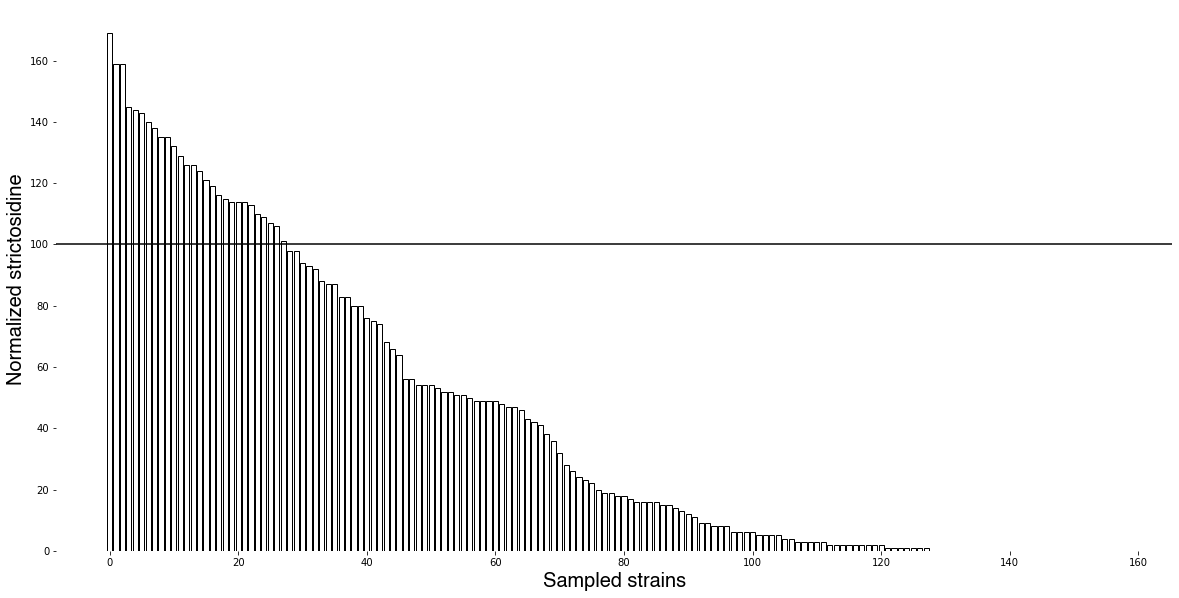

In [26]:
bar_plot(indexes,normalzed_strict, 
        path = 'ConStrain_on_google_colab/data/10-plots/10_2_TEST_Library_characterization/bar_plot_of_normalized_strict_for_all_sampled_strains', 
        title = '', 
        x_label = 'Sampled strains', 
        y_label= 'Normalized strictosidine',
        size_height = 10, 
         size_length = 20)

# 2. Genotyping

Purpose: Determine promoters from library strains to enable ML based sampling of library space

Methods:
DNA sequencing of assembled clusters. Genomic DNA was extracted from
overnight cultures using the LiOAc/SDS method adapted to a 96-well microtiter
plate format. Each extract was used as a template in 2 PCR reactions spanning
the 2 integrated promoter gene pairs and amplifying from 2500 to 3200 bp. The PCR
products were validated using gel electrophoresis and sequenced
using PlateSeq PCR Kits (Eurofins) according to the manufacturer’s instructions.

From the gel results, a PCR reaction was considered as trusted if it showed a
strong band of the correct size; not trusted if it showed a strong band of the wrong
size, and as no information (NI) gained if it showed a weak or no band. 

From the
sequencing results, a sequencing reaction was considered as trusted if it showed an
unambiguous sequence of the expected length (i.e., only limited by length of PCR
fragment, stretches of the same nucleotide in the promoter or of ~1 kb limit of
sanger sequencing reactions), not trusted if it showed an unambiguous sequence of
the expected length with an assembly error, and NI gained if there were no or bad
sequence results. If one or more sequencing results from the same strain showed
double peaks in the promoter region the strain was considered as a double
population. 

Finally, the promoter was noted as a failed assembly if either gel
and or sequencing results were considered not trusted, as NI if the sequencing
result was NI and else as the promoter predicted by pairwise alignment between
sequencing results and promoter sequence.

## 2.1 Sequencing

### Submission


Eurofins     | SDP_ID | cassette
------------ | ------ | --------
PCR_00020748 | yp53   | g8h
PCR_00020750 | yp54   | g8h
PCR_00020747 | yp53   | cpr
PCR_00020749 | yp54   | cpr

In plateseq kits well h12 is reserved for quality control.
In all 6 plates yp49-51 for g8h & cpr well h12 contains medium control which do not need to be sequenced. Thus no need to rearrange samples.



In [27]:
yp53_g8h = pd.read_excel('ConStrain_on_google_colab/data/08-sanger_sequencing/PlateSeq_files/PlateReport_yp53_g8h_Run1.xlsx')
yp53_cpr = pd.read_excel('ConStrain_on_google_colab/data/08-sanger_sequencing/PlateSeq_files/PlateReport_yp53_cpr_Run1.xlsx')
yp54_g8h = pd.read_excel('ConStrain_on_google_colab/data/08-sanger_sequencing/PlateSeq_files/PlateReport_yp54_g8h_Run1.xlsx')
yp54_cpr = pd.read_excel('ConStrain_on_google_colab/data/08-sanger_sequencing/PlateSeq_files/PlateReport_yp54_cpr_Run1.xlsx')


# list of all the dataframes
sequencing_plates = [yp53_g8h, yp53_cpr, yp54_g8h, yp54_cpr]

In [28]:
from constrain.lab.PCR import calculate_elongation_time

In [29]:
from constrain.test.genotyping import plat_seq_data_wrangler, plate_AvgQual, split_df_names, concatenating_list_of_dfs, slicing_and_naming_seq_plates

### Data wrangling of plateSeq2 excel files

In [30]:
#Slicing plate data
sliced_plates = slicing_and_naming_seq_plates(sequencing_plates)

# Making the values numeric
list_of_dfs = plat_seq_data_wrangler(sliced_plates)

#filter them on their 
filtered_plates = plate_AvgQual(list_of_dfs)

# Split names
split_df = split_df_names(filtered_plates)

# concatenating the plates
all_data_frames = concatenating_list_of_dfs(split_df)

all_data_frames.head()

,Number,Sample-Name,AvgQual,Length,GoodQualFrom,GoodQualTo,used,plate,well
7,A01,yp53re_g8h_A1,51.032787,986.0,21.0,447.0,349.0,yp53re,A1
8,A02,yp53re_g8h_A2,50.974178,980.0,22.0,447.0,349.0,yp53re,A2
10,A04,yp53re_g8h_A4,54.070009,1171.0,10.0,1066.0,1010.0,yp53re,A4
12,A06,yp53re_g8h_A6,50.528169,1025.0,21.0,446.0,352.0,yp53re,A6
13,A07,yp53re_g8h_A7,50.837367,1181.0,9.0,1041.0,939.0,yp53re,A7


In [31]:
## Adding a zero to all the numers before 10
wells = []
plates = []
for index, row in all_data_frames.iterrows():
    if len(row['well']) == 2: 
        letter, number = row['well'][0:1], row['well'][1:2]
        #print(letter, number)
        row['well'] = letter + '0' + number
        wells.append(row['well'])
    else: 
        wells.append(row['well'])
        
    if row['plate'] == 'yp53re':
        plates.append('yp53')
        
    else:
        plates.append('yp54')
        
all_data_frames['well'] = wells
all_data_frames['plate'] = plates

all_data_frames.head()

,Number,Sample-Name,AvgQual,Length,GoodQualFrom,GoodQualTo,used,plate,well
7,A01,yp53re_g8h_A1,51.032787,986.0,21.0,447.0,349.0,yp53,A01
8,A02,yp53re_g8h_A2,50.974178,980.0,22.0,447.0,349.0,yp53,A02
10,A04,yp53re_g8h_A4,54.070009,1171.0,10.0,1066.0,1010.0,yp53,A04
12,A06,yp53re_g8h_A6,50.528169,1025.0,21.0,446.0,352.0,yp53,A06
13,A07,yp53re_g8h_A7,50.837367,1181.0,9.0,1041.0,939.0,yp53,A07


### ALL reads vs used bases 

In [32]:
concating_all_plates_with_bad_reads = concatenating_list_of_dfs(sequencing_plates)
# Making the values numeric
concating_all_plates_with_bad_reads["AvgQual"] = pd.to_numeric(concating_all_plates_with_bad_reads["AvgQual"])

concating_all_plates_with_bad_reads.head()

,Number,Sample-Name,AvgQual,Length,GoodQualFrom,GoodQualTo,used
7,A01,yp53re_g8h_A1,51.032787,986.0,21.0,447.0,349.0
8,A02,yp53re_g8h_A2,50.974178,980.0,22.0,447.0,349.0
9,A03,yp53re_g8h_A3,0.000000,1337.0,0.0,0.0,21.0
10,A04,yp53re_g8h_A4,54.070009,1171.0,10.0,1066.0,1010.0
11,A05,yp53re_g8h_A5,49.158019,1026.0,22.0,445.0,347.0


In [33]:
import seaborn as sns

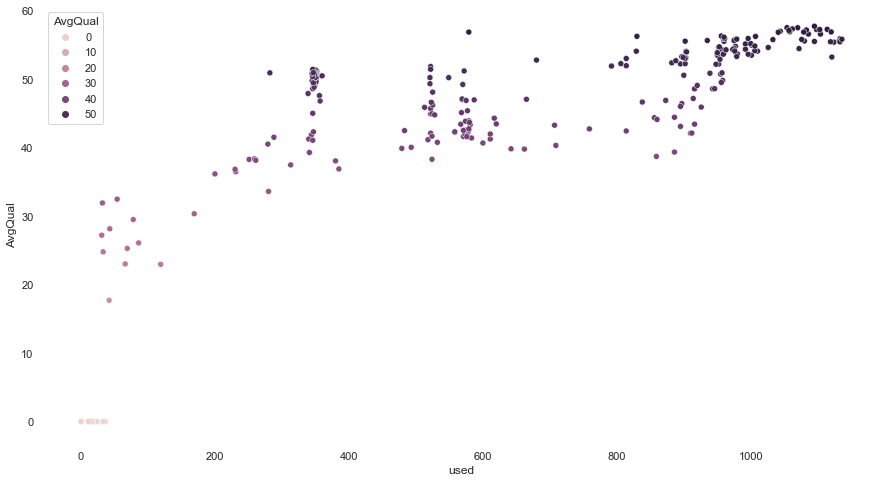

In [34]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_theme(style='white')

sns.scatterplot(data=concating_all_plates_with_bad_reads, x="used", y="AvgQual", hue="AvgQual")
sns.despine(bottom = True, left = True)
None

### AvgQual > 50 reads vs used bases 

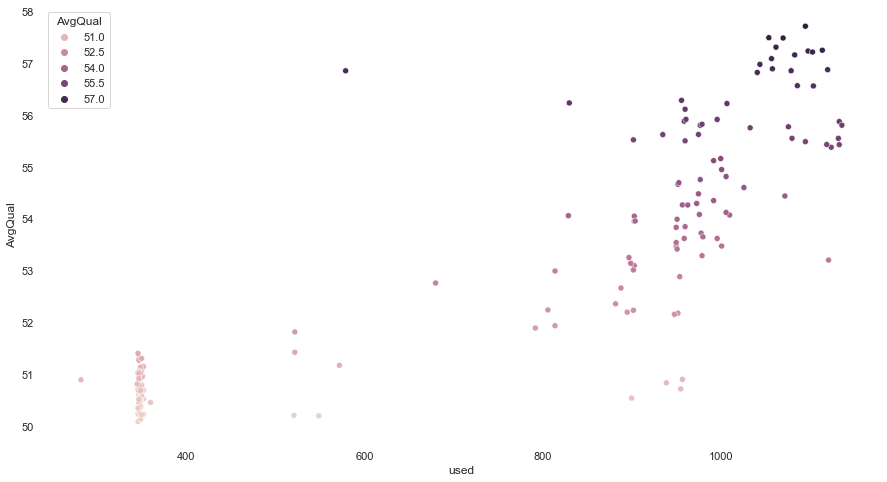

In [35]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_theme(style='white')

sns.scatterplot(data=all_data_frames, x="used", y="AvgQual", hue="AvgQual")
sns.despine(bottom = True, left = True)
None

### Infering promoter to sample relationship

#### primers

In [36]:
from Bio import SeqIO

In [37]:
from constrain.lims.csv_database import get_dna_from_box_name
get_dna_from_box_name

<function constrain.lims.csv_database.get_dna_from_box_name(name: str, database_name: str, database_path='../data/csv_database/', genbank_files_path='../data/genbank_files/', genbank=False) -> Bio.SeqRecord.SeqRecord>

In [38]:
pad_pG8H_fw = get_dna_from_box_name('pad_pG8H_fw', 'primer_box', database_path = 'ConStrain_on_google_colab/data/06-lims/csv_database/')
pad_pCPR_fw = get_dna_from_box_name('pad_pCPR_fw', 'primer_box', database_path = 'ConStrain_on_google_colab/data/06-lims/csv_database/')

In [39]:
primers_for_seq = [pad_pG8H_fw, pad_pCPR_fw]
primers_for_seq

[SeqRecord(seq=Seq('TGCCCATTCGATAAGGCA'), id='10148.0', name='pad_pG8H_fw', description='Stock of primers for G8H-CPR library ', dbxrefs=[]),
 SeqRecord(seq=Seq('GGCGTATGGACCTGTCT'), id='10144.0', name='pad_pCPR_fw', description='Stock of primers for G8H-CPR library ', dbxrefs=[])]

#### promoter

In [40]:
pG8H_template_names = ['pCYC1','pENO2']
pCPR_template_names = ['pCCW12','pTPI1']

In [41]:
path = 'ConStrain_on_google_colab/data/06-lims/csv_database/'
genbank_path = 'ConStrain_on_google_colab/data/06-lims/genbank_files/'

pG8H =[get_dna_from_box_name(name, 'ds_dna_box', database_path = path,genbank = True, genbank_files_path = genbank_path) for name in pG8H_template_names]  
pCPR =[get_dna_from_box_name(name, 'ds_dna_box', database_path = path, genbank = True, genbank_files_path = genbank_path) for name in pCPR_template_names]  

In [42]:
templates = pCPR+pG8H

In [43]:
pG8H

[SeqRecord(seq=Seq('CAGCATTTTCAAAGGTGTGTTCTTCGTCAGACATGTTTTAGTGTGTGAATGAAA...ATA'), id='10033', name='pCYC1', description='', dbxrefs=[]),
 SeqRecord(seq=Seq('AATCCTACTCTTGCCGTTGCCATCCAAAATGAGCTAGAAGGTGGATTAACAAAT...ATA'), id='10034', name='pENO2', description='', dbxrefs=[])]

In [44]:
import os
path = 'ConStrain_on_google_colab/data/08-sanger_sequencing/sanger_seq_files/ab1_yp53_54'
files = os.listdir(path)

In [45]:
reads = []
for read in files:
    if read != '.ipynb_checkpoints': 
        reads.append(SeqIO.read('ConStrain_on_google_colab/data/08-sanger_sequencing/sanger_seq_files/ab1_yp53_54/'+read, 'abi'))#
print(len(reads))

314


getting the hits that have a proper quality:
    

### Manual ab1 and promoter check 

### Detailed check of assemblies
- Manuel filtering. trusted / not_trusted ab1. 
- For certains strains multiple ab1 sequences get ambiguous only in promoters -> double population
- ab1 sequences quality drops preliminary due to stretches of same nucleotides in certain promoters  -> trusted even though small seq alignment 
- Low quality ab1 -> not_trusted


In [46]:
manual_checked = pd.read_excel('ConStrain_on_google_colab/data/08-sanger_sequencing/manual_check/sequence_check_yp53_54.xlsx')
manual_checked.head()

,plate,well,position,inf_promoter,ab1,ab1_comment,gel,gel_comment,Keep,Comment,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,yp53re,A01,2,5.0,good,good - little ambigous,good,good,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,yp53re,A01,1,1.0,good,good,good,good,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,yp53re,A02,2,5.0,good,good,good,good,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,yp53re,A02,1,1.0,good,good,good,good,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,yp53re,A03,2,NaN,no_information,no_information,no_information,small band,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Lets parse through the file and add the sequences to the all_sequences dataframe 

In [47]:
df_filterd_keep = manual_checked[manual_checked['Keep'] == True]

In [48]:
# making Sample-name from the information above
#yp49_cpr_A1_pad_cpr_fw	

sample_names = []
for index, row in df_filterd_keep.iterrows():
    if row['position'] == 1:
        name = 'g8h'
    if row['position'] == 2:
        name = 'cpr'
    
    # Getting the right nomeclature
    if row['well'][1] == '0': 
        well = row['well'][0]+row['well'][2]  
    else: 
        well = row['well']
    
    #'yp53re_g8h_F1_F01-pad_g8h_fw'
    sample_name = f"{row['plate']}_{name}_{well}_{well[0]}0{well[1]}-pad_{name}_fw" #sample_name = f"{row['plate']}_{name}_{well}_pad_{name}_fw"
    
    sample_names.append(sample_name)
    
df_filterd_keep['Sample-Name'] = sample_names


/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_7196/1319420344.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filterd_keep['Sample-Name'] = sample_names


In [49]:
df_filterd_keep.head()

,plate,well,position,inf_promoter,ab1,ab1_comment,gel,gel_comment,Keep,Comment,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Sample-Name
0,yp53re,A01,2,5.0,good,good - little ambigous,good,good,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yp53re_cpr_A1_A01-pad_cpr_fw
1,yp53re,A01,1,1.0,good,good,good,good,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yp53re_g8h_A1_A01-pad_g8h_fw
2,yp53re,A02,2,5.0,good,good,good,good,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yp53re_cpr_A2_A02-pad_cpr_fw
3,yp53re,A02,1,1.0,good,good,good,good,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yp53re_g8h_A2_A02-pad_g8h_fw
6,yp53re,A04,2,5.0,good,good - little ambigous,good,good,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yp53re_cpr_A4_A04-pad_cpr_fw


In [50]:
# Sample-Name	inf_part_name	align_score	inf_part_number
df_filterd_keep = df_filterd_keep[['Sample-Name', 'inf_promoter']]
df_filterd_keep.columns = ['Sample-Name', 'inf_part_number']
df_filterd_keep.head()

,Sample-Name,inf_part_number
0,yp53re_cpr_A1_A01-pad_cpr_fw,5.0
1,yp53re_g8h_A1_A01-pad_g8h_fw,1.0
2,yp53re_cpr_A2_A02-pad_cpr_fw,5.0
3,yp53re_g8h_A2_A02-pad_g8h_fw,1.0
6,yp53re_cpr_A4_A04-pad_cpr_fw,5.0


## 2.2 Aligning promoters to reads - infer promoter alignment

In [51]:
list_of_promoters = ["pCYC1", "pENO2","pPCK1","pRPL15B", "pCCW12", "pTPI1","pMLS1","pURE2"]
numbers_list = [1, 2, 3, 4, 5, 6, 7, 8]

In [52]:
dict_of_promoters_and_numbers = {list_of_promoters[i]: numbers_list[i] for i in range(len(list_of_promoters))}
dict_of_promoters_and_numbers

{'pCYC1': 1,
 'pENO2': 2,
 'pPCK1': 3,
 'pRPL15B': 4,
 'pCCW12': 5,
 'pTPI1': 6,
 'pMLS1': 7,
 'pURE2': 8}

In [53]:
for i in range(len(templates)): 
    templates[i].description = dict_of_promoters_and_numbers[templates[i].name]
       
templates

[SeqRecord(seq=Seq('AAAGAAACTTAATACGTTATGCCGTAATGAAGGGCTACCAAAAACGATAATCTC...ATA'), id='10037', name='pCCW12', description=5, dbxrefs=[]),
 SeqRecord(seq=Seq('AAGGATGAGCCAAGAATAAGGGAACAAGATTTTGGTAATTTCCAAAAAATCAAT...AAA'), id='10039', name='pTPI1', description=6, dbxrefs=[]),
 SeqRecord(seq=Seq('CAGCATTTTCAAAGGTGTGTTCTTCGTCAGACATGTTTTAGTGTGTGAATGAAA...ATA'), id='10033', name='pCYC1', description=1, dbxrefs=[]),
 SeqRecord(seq=Seq('AATCCTACTCTTGCCGTTGCCATCCAAAATGAGCTAGAAGGTGGATTAACAAAT...ATA'), id='10034', name='pENO2', description=2, dbxrefs=[])]

### Tidying up data  

Since the library only was made with four promoters we will fetch those out so we dont have to align with the rest



In [54]:
# lets limit the alingment to only reads that are of proper quality
# all_data_frames
sample_names = df_filterd_keep['Sample-Name'].tolist()
print(len(sample_names))

good_samples = []
for i in range(len(reads)):
    for j in range(len(sample_names)): 
        if reads[i].name == sample_names[j]: 
            good_samples.append(reads[i])
            
            
len(good_samples)

279


210

## 2.3 Aligning with the pairwise_alignment_of_templates function

In [55]:
from constrain.test.genotyping import pairwise_alignment_of_templates

In [56]:
%%time
df_alignment = pairwise_alignment_of_templates(reads,templates, primers_for_seq)

df_alignment

CPU times: user 6.08 s, sys: 72.9 ms, total: 6.15 s
Wall time: 6.18 s


,Sample-Name,inf_part_name,align_score,inf_part_number
0,yp54_cpr_C5_C05-pad_cpr_fw,pTPI1,966.0,6
1,yp53re_cpr_D1_D01-pad_cpr_fw,pTPI1,925.0,6
2,yp54_g8h_D1_D01-pad_g8h_fw,pCYC1,530.0,1
3,yp53re_g8h_C5_C05-pad_g8h_fw,pCYC1,502.0,1
4,yp54_cpr_A2_A02-pad_cpr_fw,pCCW12,799.0,5
...,...,...,...,...
309,yp53re_g8h_B9_B09-pad_g8h_fw,pENO2,959.0,2
310,yp54_cpr_A6_A06-pad_cpr_fw,pCCW12,121.0,5
311,yp54_cpr_B9_B09-pad_cpr_fw,pTPI1,968.0,6
312,yp53re_g8h_A6_A06-pad_g8h_fw,pCYC1,520.0,1


In [57]:
col_list =  list(df_alignment["align_score"])
print(col_list)

[966.0, 925.0, 530.0, 502.0, 799.0, 964.0, 886.0, 944.0, 512.0, 868.0, 507.0, 882.0, 504.0, 963.0, 611.0, 959.0, 512.0, 790.0, 964.0, 906.0, 957.0, 952.0, 954.0, 930.0, 968.0, 717.0, 965.0, 521.0, 964.0, 964.0, 498.0, 643.0, 942.0, 201.0, 511.0, 509.0, 959.0, 644.0, 811.0, 519.0, 512.0, 636.0, 766.0, 493.0, 512.0, 856.0, 969.0, 521.0, 965.0, 516.0, 663.0, 968.0, 944.0, 963.0, 857.0, 954.0, 798.0, 956.0, 964.0, 532.0, 874.0, 789.0, 509.0, 504.0, 484.0, 527.0, 662.0, 523.0, 648.0, 648.0, 515.0, 945.0, 965.0, 810.0, 630.0, 522.0, 529.0, 885.0, 684.0, 896.0, 972.0, 957.0, 964.0, 504.0, 828.0, 528.0, 488.0, 107.0, 957.0, 700.0, 961.0, 820.0, 523.0, 543.0, 780.0, 958.0, 521.0, 528.0, 926.0, 967.0, 967.0, 967.0, 957.0, 627.0, 681.0, 963.0, 518.0, 953.0, 464.0, 955.0, 519.0, 605.0, 398.0, 691.0, 963.0, 482.0, 529.0, 313.0, 790.0, 504.0, 688.0, 967.0, 505.0, 873.0, 954.0, 518.0, 247.0, 782.0, 584.0, 955.0, 951.0, 970.0, 634.0, 637.0, 599.0, 524.0, 509.0, 513.0, 513.0, 945.0, 515.0, 515.0, 493.0

In [58]:
minvalue = df_alignment['align_score'].min()
minvalue

28.0

In [59]:
df_align_sort = df_alignment.sort_values(['Sample-Name'])
df_align_sort

,Sample-Name,inf_part_name,align_score,inf_part_number
132,yp53re_cpr_A10_A10-pad_cpr_fw,pCCW12,634.0,5
188,yp53re_cpr_A11_A11-pad_cpr_fw,pTPI1,904.0,6
247,yp53re_cpr_A12_A12-pad_cpr_fw,pTPI1,851.0,6
93,yp53re_cpr_A1_A01-pad_cpr_fw,pCCW12,543.0,5
41,yp53re_cpr_A2_A02-pad_cpr_fw,pCCW12,636.0,5
...,...,...,...,...
238,yp54_g8h_F9_F09-pad_g8h_fw,pCYC1,584.0,1
241,yp54_g8h_G1_G01-pad_g8h_fw,pENO2,446.0,2
217,yp54_g8h_G2_G02-pad_g8h_fw,pENO2,484.0,2
117,yp54_g8h_G3_G03-pad_g8h_fw,pENO2,313.0,2


#### Check with manual curation

In [60]:
df_align_sort_by_pairwise_alignment = df_align_sort[['Sample-Name','inf_part_number' ]]

# Merge and calculate diff - if more than 0 there is a discrepancy
df_align_sort_by_pairwise_alignment_MERGED = pd.merge(df_align_sort_by_pairwise_alignment, df_filterd_keep, on=['Sample-Name'])
df_align_sort_by_pairwise_alignment_MERGED['diff'] = df_align_sort_by_pairwise_alignment_MERGED['inf_part_number_x'] - df_align_sort_by_pairwise_alignment_MERGED['inf_part_number_y']

df_align_diff = df_align_sort_by_pairwise_alignment_MERGED.loc[df_align_sort_by_pairwise_alignment_MERGED['diff'] != 0]

df_align_diff

,Sample-Name,inf_part_number_x,inf_part_number_y,diff
56,yp53re_cpr_G6_G06-pad_cpr_fw,1,8.0,-7.0
57,yp53re_cpr_G7_G07-pad_cpr_fw,1,8.0,-7.0


In [61]:
# Updating the values
df_align_sort.loc[df_align_diff.index[0],['inf_part_number']] = 8
df_align_sort.loc[df_align_diff.index[1],['inf_part_number']] = 8

In [62]:
print(df_align_sort.loc[56,['inf_part_number'] ])
print(df_align_sort.loc[57,['inf_part_number'] ])

inf_part_number    8
Name: 56, dtype: object
inf_part_number    8
Name: 57, dtype: object


In [63]:
df_alignment['position'] = ''
position = []
plate_list = []
well_list = []

for index, row in df_alignment.iterrows():
    # Split data
    split = str(row['Sample-Name'].split("_")[1])
    plate = str(row['Sample-Name'].split("_")[0])
    well = str(row['Sample-Name'].split("_")[3])
    
    # get the right position 
    if split == 'g8h': 
        position.append(1)
    if split == 'cpr': 
        position.append(2)
    plate_list.append(plate[0:4])
    well_list.append(well[0:3])
    
    
df_alignment['position'] = position
df_alignment['plate'] = plate_list
df_alignment['well'] = well_list
print('Duplicated samples:', df_alignment.duplicated(subset=['Sample-Name']).sum())

df_alignment.head()

Duplicated samples: 4


,Sample-Name,inf_part_name,align_score,inf_part_number,position,plate,well
0,yp54_cpr_C5_C05-pad_cpr_fw,pTPI1,966.0,6,2,yp54,C05
1,yp53re_cpr_D1_D01-pad_cpr_fw,pTPI1,925.0,6,2,yp53,D01
2,yp54_g8h_D1_D01-pad_g8h_fw,pCYC1,530.0,1,1,yp54,D01
3,yp53re_g8h_C5_C05-pad_g8h_fw,pCYC1,502.0,1,1,yp53,C05
4,yp54_cpr_A2_A02-pad_cpr_fw,pCCW12,799.0,5,2,yp54,A02


In [64]:
df_alignment = df_alignment.drop_duplicates(subset = ['Sample-Name'])
print('Duplicated samples:', df_alignment.duplicated(subset=['Sample-Name']).sum())
print('Lenght of the dataframe :', len(df_alignment))


Duplicated samples: 0
Lenght of the dataframe : 310


grouping the positions

In [65]:
grouped = df_alignment.groupby(df_alignment.position)
g8h_df = grouped.get_group(1)
cpr_df = grouped.get_group(2)
print('Duplicated samples in g8h:', g8h_df.duplicated(subset=['Sample-Name']).sum())
print('Duplicated samples in cpr:', cpr_df.duplicated(subset=['Sample-Name']).sum())

cpr_df

Duplicated samples in g8h: 0
Duplicated samples in cpr: 0


,Sample-Name,inf_part_name,align_score,inf_part_number,position,plate,well
0,yp54_cpr_C5_C05-pad_cpr_fw,pTPI1,966.0,6,2,yp54,C05
1,yp53re_cpr_D1_D01-pad_cpr_fw,pTPI1,925.0,6,2,yp53,D01
4,yp54_cpr_A2_A02-pad_cpr_fw,pCCW12,799.0,5,2,yp54,A02
6,yp53re_cpr_F6_F06-pad_cpr_fw,pTPI1,886.0,6,2,yp53,F06
9,yp53re_cpr_E9_E09-pad_cpr_fw,pTPI1,868.0,6,2,yp53,E09
...,...,...,...,...,...,...,...
304,yp54_cpr_C1_C01-pad_cpr_fw,pTPI1,960.0,6,2,yp54,C01
307,yp54_cpr_F12_F12-pad_cpr_fw,pTPI1,584.0,6,2,yp54,F12
308,yp53re_cpr_F2_F02-pad_cpr_fw,pCCW12,711.0,5,2,yp53,F02
310,yp54_cpr_A6_A06-pad_cpr_fw,pCCW12,121.0,5,2,yp54,A06


In [66]:
print('Duplicated samples:', cpr_df.duplicated(subset=['Sample-Name']).sum())

Duplicated samples: 0


In [67]:
cpr_df.head()

,Sample-Name,inf_part_name,align_score,inf_part_number,position,plate,well
0,yp54_cpr_C5_C05-pad_cpr_fw,pTPI1,966.0,6,2,yp54,C05
1,yp53re_cpr_D1_D01-pad_cpr_fw,pTPI1,925.0,6,2,yp53,D01
4,yp54_cpr_A2_A02-pad_cpr_fw,pCCW12,799.0,5,2,yp54,A02
6,yp53re_cpr_F6_F06-pad_cpr_fw,pTPI1,886.0,6,2,yp53,F06
9,yp53re_cpr_E9_E09-pad_cpr_fw,pTPI1,868.0,6,2,yp53,E09


In [68]:
all_data_frames.head()

,Number,Sample-Name,AvgQual,Length,GoodQualFrom,GoodQualTo,used,plate,well
7,A01,yp53re_g8h_A1,51.032787,986.0,21.0,447.0,349.0,yp53,A01
8,A02,yp53re_g8h_A2,50.974178,980.0,22.0,447.0,349.0,yp53,A02
10,A04,yp53re_g8h_A4,54.070009,1171.0,10.0,1066.0,1010.0,yp53,A04
12,A06,yp53re_g8h_A6,50.528169,1025.0,21.0,446.0,352.0,yp53,A06
13,A07,yp53re_g8h_A7,50.837367,1181.0,9.0,1041.0,939.0,yp53,A07


In [69]:
all_data_frames.duplicated(subset=['Sample-Name']).sum()

0

In [70]:
# lets merge the quality dataframe
infered_promoters_df = pd.merge(all_data_frames, df_alignment, on=['plate', 'well'])

In [71]:
infered_promoters_df.head()

,Number,Sample-Name_x,AvgQual,Length,GoodQualFrom,GoodQualTo,used,plate,well,Sample-Name_y,inf_part_name,align_score,inf_part_number,position
0,A01,yp53re_g8h_A1,51.032787,986.0,21.0,447.0,349.0,yp53,A01,yp53re_cpr_A1_A01-pad_cpr_fw,pCCW12,543.0,5,2
1,A01,yp53re_g8h_A1,51.032787,986.0,21.0,447.0,349.0,yp53,A01,yp53re_g8h_A1_A01-pad_g8h_fw,pCYC1,518.0,1,1
2,A02,yp53re_g8h_A2,50.974178,980.0,22.0,447.0,349.0,yp53,A02,yp53re_g8h_A2_A02-pad_g8h_fw,pCYC1,507.0,1,1
3,A02,yp53re_g8h_A2,50.974178,980.0,22.0,447.0,349.0,yp53,A02,yp53re_cpr_A2_A02-pad_cpr_fw,pCCW12,636.0,5,2
4,A04,yp53re_g8h_A4,54.070009,1171.0,10.0,1066.0,1010.0,yp53,A04,yp53re_g8h_A4_A04-pad_g8h_fw,pENO2,957.0,2,1


In [72]:
infered_promoters_df = infered_promoters_df[["plate", "well", "inf_part_number", "position"]]
infered_promoters_df.head()

,plate,well,inf_part_number,position
0,yp53,A01,5,2
1,yp53,A01,1,1
2,yp53,A02,1,1
3,yp53,A02,5,2
4,yp53,A04,2,1


In [73]:
# grouping
grouped = infered_promoters_df.groupby(infered_promoters_df.position)
g8h_df = grouped.get_group(1)
cpr_df = grouped.get_group(2)

#filtering
g8h_df = g8h_df[["plate", "well", "inf_part_number"]]
cpr_df = cpr_df[["plate", "well", "inf_part_number"]]

# changing names
g8h_df.columns = ['plate', 'well', 'inf_promoter1']
cpr_df.columns = ['plate', 'well', 'inf_promoter2']

promoter_to_well = pd.merge(g8h_df, cpr_df, on=['plate','well' ])
promoter_to_well.head()

,plate,well,inf_promoter1,inf_promoter2
0,yp53,A01,1,5
1,yp53,A02,1,5
2,yp53,A04,2,5
3,yp53,A06,1,5
4,yp53,A07,2,6


In [74]:
print(promoter_to_well.duplicated(subset=['plate', 'well']).sum())

102


In [75]:
print(len(g8h_df))
print(len(cpr_df))

170
171


In [76]:
df_alignment['inf_part_number'] = df_alignment['inf_part_number'].astype('int')

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_7196/4105919879.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alignment['inf_part_number'] = df_alignment['inf_part_number'].astype('int')


Sanity check - did we get the correct promoters in each well? 


In [77]:
bad_indexes = []

for index, row in df_alignment.iterrows():
    if row['position'] == 1 and row['inf_part_number'] > 4:
        print('SOMTHING WRONG WITH G8H', row['align_score'], index)
        bad_indexes.append(index)
    if row['position'] == 2 and int(row['inf_part_number']) < 5:
        print('SOMTHING WRONG WITH CPR', row['align_score'], index)
        bad_indexes.append(index)
bad_indexes

SOMTHING WRONG WITH CPR 630.0 74
SOMTHING WRONG WITH CPR 639.0 165
SOMTHING WRONG WITH G8H 247.0 190
SOMTHING WRONG WITH CPR 587.0 298


[74, 165, 190, 298]

In [78]:
# dropping the wrong indexes
df_alignment.drop(bad_indexes, axis=0, inplace=True)
df_alignment.head()

/Users/lucaslevassor/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Sample-Name,inf_part_name,align_score,inf_part_number,position,plate,well
0,yp54_cpr_C5_C05-pad_cpr_fw,pTPI1,966.0,6,2,yp54,C05
1,yp53re_cpr_D1_D01-pad_cpr_fw,pTPI1,925.0,6,2,yp53,D01
2,yp54_g8h_D1_D01-pad_g8h_fw,pCYC1,530.0,1,1,yp54,D01
3,yp53re_g8h_C5_C05-pad_g8h_fw,pCYC1,502.0,1,1,yp53,C05
4,yp54_cpr_A2_A02-pad_cpr_fw,pCCW12,799.0,5,2,yp54,A02


# 3. Combine data


In [79]:
promoter_genotype_relationship = pd.merge(promoter_to_well, sorted_df_lcms, on=['plate','well' ])
len(promoter_genotype_relationship)

237

In [80]:
promoter_genotype_relationship["genotype"]= promoter_genotype_relationship["genotype"].astype(str)
promoter_genotype_relationship = promoter_genotype_relationship.loc[promoter_genotype_relationship['genotype'] != 'nan']

In [81]:
g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]


g8h_genotype = []
cpr_genotype = []

# adding index of genotypes to individual rows 
for index, row in promoter_genotype_relationship.iterrows():
    g8h_geno = str(row['genotype'].split(" ")[0])
    cpr_geno = str(row['genotype'].split(" ")[1])
    
    g8h_pos = g8h_list_of_index.index(str(row['genotype'].split(" ")[0]))+1
    cpr_pos = cpr_list_of_index.index(str(row['genotype'].split(" ")[1]))+1

    
    g8h_genotype.append(g8h_pos)
    cpr_genotype.append(cpr_pos)
    
promoter_genotype_relationship['G8H'] = g8h_genotype
promoter_genotype_relationship['CPR'] = cpr_genotype
    
print(len(promoter_genotype_relationship))
promoter_genotype_relationship.head()

222


,plate,well,inf_promoter1,inf_promoter2,index,data_file,sample_notes,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,strain,col_no,genotype,medium,norm_strict_%,G8H,CPR
0,yp53,A01,1,5,0,210927_TMET576_016.xms,96WP1232_A1,180064.781,0.000000,0.0,2.546823,1123.859574,MIA-HA-116,1.0,VminG8H AanCPR,YPD,9,4,2
1,yp53,A02,1,5,1,210927_TMET576_017.xms,96WP1232_A2,146340.297,0.000000,0.0,7.921696,913.370971,MIA-HA-116,2.0,VminG8H AanCPR,YPD,28,4,2
2,yp53,A04,2,5,3,210927_TMET576_019.xms,96WP1232_A4,131989.250,1.501260,0.0,22.597750,823.800087,MIA-HA-116,4.0,VminG8H AanCPR,YPD,80,4,2
3,yp53,A06,1,5,5,210927_TMET576_021.xms,96WP1232_A6,125531.602,2.838788,0.0,34.235068,783.495207,MIA-HA-117,2.0,SmusG8H AanCPR,YPD,121,5,2
4,yp53,A07,2,6,6,210927_TMET576_022.xms,96WP1232_A7,131414.891,7.860359,0.0,44.719792,820.215273,MIA-HA-117,3.0,SmusG8H AanCPR,YPD,159,5,2


make new dataframe of promoters: 


plate


In [82]:
promoter_genotype_relationship = promoter_genotype_relationship[['plate', 'well', 'G8H','inf_promoter1', 'inf_promoter2', 'CPR','norm_strict_%', 'Amt_uM_Strictosidine']]
promoter_genotype_relationship.head()

,plate,well,G8H,inf_promoter1,inf_promoter2,CPR,norm_strict_%,Amt_uM_Strictosidine
0,yp53,A01,4,1,5,2,9,2.546823
1,yp53,A02,4,1,5,2,28,7.921696
2,yp53,A04,4,2,5,2,80,22.597750
3,yp53,A06,5,1,5,2,121,34.235068
4,yp53,A07,5,2,6,2,159,44.719792


In [83]:
promoter_genotype_relationship['Line_name'] = promoter_genotype_relationship['plate'] + '_' + promoter_genotype_relationship['well']

In [84]:
#promoter_genotype_relationship = promoter_genotype_relationship.drop_duplicates(subset = 'Line_name', keep=False)
len(promoter_genotype_relationship)

222

In [85]:
print(promoter_genotype_relationship.duplicated(subset = ['Line_name']).sum())
promoter_genotype_relationship_for_ml_ALL = promoter_genotype_relationship.drop_duplicates(subset='Line_name')
promoter_genotype_relationship_for_ml_ALL.head()

93


,plate,well,G8H,inf_promoter1,inf_promoter2,CPR,norm_strict_%,Amt_uM_Strictosidine,Line_name
0,yp53,A01,4,1,5,2,9,2.546823,yp53_A01
1,yp53,A02,4,1,5,2,28,7.921696,yp53_A02
2,yp53,A04,4,2,5,2,80,22.597750,yp53_A04
3,yp53,A06,5,1,5,2,121,34.235068,yp53_A06
4,yp53,A07,5,2,6,2,159,44.719792,yp53_A07


#### 3.1 saving it for ml second round

In [86]:
promoter_genotype_relationship_for_ml_ALL = promoter_genotype_relationship_for_ml_ALL[['Line_name', 'G8H','inf_promoter1', 'inf_promoter2', 'CPR', 'Amt_uM_Strictosidine', 'norm_strict_%' ]]

promoter_genotype_relationship_for_ml_ALL.columns = ['Line_name', '0','1', '2', '3','Amt_uM_Strictosidine', 'Amt_norm']
promoter_genotype_relationship_for_ml_ALL.head()

,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm
0,yp53_A01,4,1,5,2,2.546823,9
1,yp53_A02,4,1,5,2,7.921696,28
2,yp53_A04,4,2,5,2,22.597750,80
3,yp53_A06,5,1,5,2,34.235068,121
4,yp53_A07,5,2,6,2,44.719792,159


In [87]:
promoter_genotype_relationship_for_ml_ALL.to_csv('ConStrain_on_google_colab/data/09-AutoML/input_to_ml/second_round/input_for_ml_2nd_iteration_all_analytics.csv',index=False )

# 4. Plotting:

In [88]:
input_for_ml = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/input_to_ml/second_round/input_for_ml_2nd_iteration_all_analytics.csv', index_col= False)
input_for_ml

,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm
0,yp53_A01,4,1,5,2,2.546823,9
1,yp53_A02,4,1,5,2,7.921696,28
2,yp53_A04,4,2,5,2,22.597750,80
3,yp53_A06,5,1,5,2,34.235068,121
4,yp53_A07,5,2,6,2,44.719792,159
...,...,...,...,...,...,...,...
124,yp54_A04,4,1,6,1,4.326963,15
125,yp54_C04,5,2,6,3,26.634041,94
126,yp54_C09,3,1,6,3,13.122270,46
127,yp54_D12,5,1,6,6,1.049920,3


### Stacked barplot

In [89]:
list_of_promoters = ["pCYC1", "pENO2","pPCK1","pRPL15B", "pCCW12", "pTPI1","pMLS1","pURE2"]
promoter_dict = {i+1:list_of_promoters[i]for i in range(len(list_of_promoters))}

In [90]:
g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]

pg8h_list_of_index = ['pCYC1', 'pENO2']
pcpr_list_of_index = ['pCCW12', 'pTPI1'] 

g8h_genotype = []
cpr_genotype = []
pg8h_genotype = []
pcpr_genotype = []

# adding index of genotypes to individual rows 
for index, row in input_for_ml.iterrows():
    # homologs
    g8h_name = g8h_list_of_index[int(row['0']-1)]
    cpr_name = cpr_list_of_index[int(row['3']-1)]
    
    # promoters
    pg8h_name =promoter_dict[row['1']]
    pcpr_name = promoter_dict[row['2']]
    
    
    # save the genotypes
    g8h_genotype.append(g8h_name)
    cpr_genotype.append(cpr_name)
    pg8h_genotype.append(pg8h_name)
    pcpr_genotype.append(pcpr_name)

    
input_for_ml['G8H'] = g8h_genotype
input_for_ml['CPR'] = cpr_genotype
input_for_ml['pG8H'] = pg8h_genotype
input_for_ml['pCPR'] = pcpr_genotype
    
len(input_for_ml)

129

In [91]:
for_plotting_input_for_ml = input_for_ml[['Line_name', 'G8H', 'pG8H','pCPR', 'CPR','Amt_norm' ]]
for_plotting_input_for_ml

,Line_name,G8H,pG8H,pCPR,CPR,Amt_norm
0,yp53_A01,VminG8H,pCYC1,pCCW12,AanCPR,9
1,yp53_A02,VminG8H,pCYC1,pCCW12,AanCPR,28
2,yp53_A04,VminG8H,pENO2,pCCW12,AanCPR,80
3,yp53_A06,SmusG8H,pCYC1,pCCW12,AanCPR,121
4,yp53_A07,SmusG8H,pENO2,pTPI1,AanCPR,159
...,...,...,...,...,...,...
124,yp54_A04,VminG8H,pCYC1,pTPI1,CroCPR,15
125,yp54_C04,SmusG8H,pENO2,pTPI1,AraCPR,94
126,yp54_C09,CroG8H,pCYC1,pTPI1,AraCPR,46
127,yp54_D12,SmusG8H,pCYC1,pTPI1,AhuCPR,3


In [92]:
g8h_counts = pd.DataFrame(for_plotting_input_for_ml["G8H"].value_counts())
pg8h_counts = pd.DataFrame(for_plotting_input_for_ml["pG8H"].value_counts())
pcpr_counts = pd.DataFrame(for_plotting_input_for_ml["pCPR"].value_counts())
cpr_counts = pd.DataFrame(for_plotting_input_for_ml["CPR"].value_counts())

all_counts = pd.concat([g8h_counts,pg8h_counts,pcpr_counts, cpr_counts ])

In [93]:
g8h_counts = dict(for_plotting_input_for_ml["G8H"].value_counts())
pg8h_counts = dict(for_plotting_input_for_ml["pG8H"].value_counts())
pcpr_counts = dict(for_plotting_input_for_ml["pCPR"].value_counts())
cpr_counts = dict(for_plotting_input_for_ml["CPR"].value_counts())

all_counts_as_list = [g8h_counts,pg8h_counts,pcpr_counts,cpr_counts]

In [94]:
from constrain.utils import counting_occurences

In [95]:
# Occurences
names_list = ['G8H', 'pG8H', 'pCPR', 'CPR']

dataframes = []
for i in range(len(all_counts_as_list)): 
    data, columns = counting_occurences(all_counts_as_list[i])
    dataframes.append(pd.DataFrame(data, columns=[names_list[i]], index=columns))

In [96]:
all_df_for_stacked_plot = pd.concat(dataframes)
all_df_for_stacked_plot = all_df_for_stacked_plot.T
all_df_for_stacked_plot

,VminG8H,OeuG8H,RsepG8H,CroG8H,SmusG8H,pCYC1,pENO2,pTPI1,pCCW12,AanCPR,AniCPR,RseCPR,CroCPR,AhuCPR,CloCPR,AraCPR
G8H,20.930233,20.930233,20.155039,19.379845,18.604651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pG8H,NaN,NaN,NaN,NaN,NaN,55.03876,44.96124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pCPR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.139535,41.860465,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CPR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.503876,15.503876,14.728682,13.953488,13.953488,13.178295,13.178295


In [97]:
from constrain.plotting.plotting import color_range_dict

In [98]:
from constrain.plotting.plotting import color_range_dict
# importing a range of colors
cpr_color = color_range_dict()['yellow'][::3][::-1]
print(len(cpr_color))
pcpr_color = color_range_dict()['orange'][::11][::-1]
print(len(pcpr_color))
g8H_color= color_range_dict()['blue'][::5][::-1]
print(len(g8H_color))
pg8h_color = color_range_dict()['green'][::10][::-1]
print(len(pg8h_color))

7
2
5
2


Making one list of all the colors

In [99]:
all_colors1 = g8H_color+ pg8h_color+ pcpr_color  +cpr_color

In [100]:
from constrain.plotting.plotting import plot_stacked_barplot_with_labels

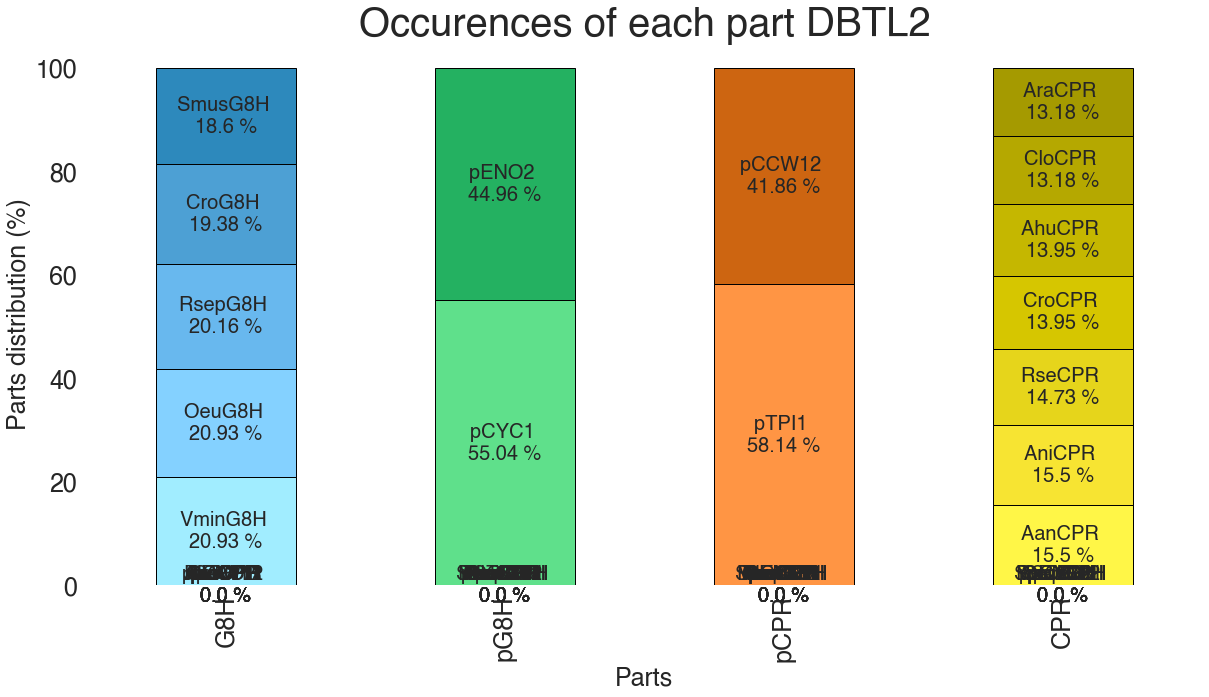

In [101]:
plot_stacked_barplot_with_labels(all_df_for_stacked_plot,all_colors1, 
                    title = 'Occurences of each part DBTL2', 
                    y_label = 'Parts' ,
                    x_label = 'Parts distribution (%)',
                    path = 'ConStrain_on_google_colab/data/10-plots/10_2_TEST_Library_characterization/'
                                )

### Horisontal bar plots top20

In [102]:
second_round_top_producers = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/input_to_ml/second_round/input_for_ml_2nd_iteration_all_analytics.csv')
second_round_top_producers = second_round_top_producers.sort_values(by='Amt_norm', ascending=False)
second_round_top_producers

,Line_name,0,1,2,3,Amt_uM_Strictosidine,Amt_norm
38,yp53_D09,5,2,6,5,47.692027,169
26,yp53_C06,6,2,6,4,44.848557,159
4,yp53_A07,5,2,6,2,44.719792,159
42,yp53_E02,6,2,6,5,40.809806,145
11,yp53_B02,3,2,6,2,40.761943,144
...,...,...,...,...,...,...,...
62,yp53_F11,6,1,6,7,0.093646,0
63,yp53_F12,6,1,6,7,0.000000,0
65,yp53_G02,3,1,6,7,0.243715,0
66,yp53_G03,3,1,5,7,0.000000,0


In [103]:
second_round_top_producers = second_round_top_producers[['Line_name','0','1','2','3','Amt_norm']]

In [104]:
list_of_promoters = ["pCYC1", "pENO2","pPCK1","pRPL15B", "pCCW12", "pTPI1","pMLS1","pURE2"]

promoter_dict = {i+1:list_of_promoters[i]for i in range(len(list_of_promoters))}
g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]


list_of_promoters = ["pCYC1", "pENO2","pPCK1","pRPL15B", "pCCW12", "pTPI1","pMLS1","pURE2"]
pg8h_list_of_index = ['pCYC1', 'pENO2']
pcpr_list_of_index = ['pCCW12', 'pTPI1'] 

g8h_genotype = []
cpr_genotype = []
pg8h_genotype = []
pcpr_genotype = []

# adding index of genotypes to individual rows 
for index, row in second_round_top_producers.iterrows():
    # homologs
    g8h_name = g8h_list_of_index[int(row['0']-1)]
    cpr_name = cpr_list_of_index[int(row['3']-1)]
    
    # promoters
    pg8h_name =promoter_dict[row['1']]
    pcpr_name = promoter_dict[row['2']]
    
    
    # save the genotypes
    g8h_genotype.append(g8h_name)
    cpr_genotype.append(cpr_name)
    pg8h_genotype.append(pg8h_name)
    pcpr_genotype.append(pcpr_name)

second_round_top_producers['G8H'] = g8h_genotype
second_round_top_producers['CPR'] = cpr_genotype
second_round_top_producers['pG8H'] = pg8h_genotype
second_round_top_producers['pCPR'] = pcpr_genotype

In [105]:
# Using DataFrame.agg() to combine two columns of text
second_round_top_producers["Names"] = second_round_top_producers[['G8H', 'pG8H','pCPR', 'CPR']].agg('-'.join, axis=1)

# Select top20
second_round_top_producers = second_round_top_producers[:20][::-1]
second_round_top_producers= second_round_top_producers.reset_index()
second_round_top_producers

,index,Line_name,0,1,2,3,Amt_norm,G8H,CPR,pG8H,pCPR,Names
0,39,yp53_D10,5,1,6,5,110,SmusG8H,RseCPR,pCYC1,pTPI1,SmusG8H-pCYC1-pTPI1-RseCPR
1,72,yp54_A05,5,2,6,1,113,SmusG8H,CroCPR,pENO2,pTPI1,SmusG8H-pENO2-pTPI1-CroCPR
2,77,yp54_A11,6,2,5,1,114,RsepG8H,CroCPR,pENO2,pCCW12,RsepG8H-pENO2-pCCW12-CroCPR
3,75,yp54_A09,6,2,6,1,114,RsepG8H,CroCPR,pENO2,pTPI1,RsepG8H-pENO2-pTPI1-CroCPR
4,78,yp54_A12,6,2,5,1,114,RsepG8H,CroCPR,pENO2,pCCW12,RsepG8H-pENO2-pCCW12-CroCPR
5,82,yp54_B05,7,2,6,1,115,OeuG8H,CroCPR,pENO2,pTPI1,OeuG8H-pENO2-pTPI1-CroCPR
6,95,yp54_C10,3,2,5,3,116,CroG8H,AraCPR,pENO2,pCCW12,CroG8H-pENO2-pCCW12-AraCPR
7,3,yp53_A06,5,1,5,2,121,SmusG8H,AanCPR,pCYC1,pCCW12,SmusG8H-pCYC1-pCCW12-AanCPR
8,23,yp53_C02,5,1,6,4,124,SmusG8H,CloCPR,pCYC1,pTPI1,SmusG8H-pCYC1-pTPI1-CloCPR
9,14,yp53_B05,7,2,6,2,126,OeuG8H,AanCPR,pENO2,pTPI1,OeuG8H-pENO2-pTPI1-AanCPR


In [106]:
index_list = list(second_round_top_producers.index)
index_list = index_list[::-1]
index_list = [str(i) for i in index_list]

In [107]:
# adding index to names
second_round_top_producers['new_index'] = index_list
second_round_top_producers['Names_index'] = second_round_top_producers[['new_index','Names']].agg('-'.join, axis=1)
names_with_index_top20 = list(second_round_top_producers['Names_index'])


In [108]:
indexes_top20 = list(second_round_top_producers.index)
names_top20 = list(second_round_top_producers['Names_index'])
normalized_strict_top20 = list(second_round_top_producers['Amt_norm'])


In [109]:
from constrain.plotting.plotting import horisontal_bar_plot

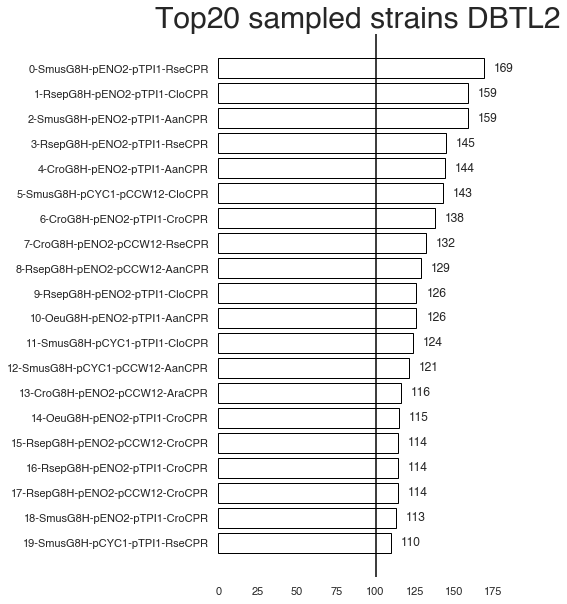

In [110]:
horisontal_bar_plot(names_top20, normalized_strict_top20, 
                   path= 'ConStrain_on_google_colab/data/10-plots/10_2_TEST_Library_characterization/Top20_strains_second_analytcs', 
                   title = 'Top20 sampled strains DBTL2', 
                   size_height=5, 
                   size_length=10)

# 5. Library statistics

### 5.1 Library from 1st round

In [111]:
first_round = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/input_to_ml/first_round/input_for_ml_1st_iteration_all_analytics.csv')
first_round = first_round[['0','1','2','3']]
len(first_round) 

167

In [112]:
# Are there any duplicated 
duplicateRows1 = first_round[first_round.duplicated(['0','1','2','3'])]
print('Unique genotypes from 1st round :', len(first_round) -len(duplicateRows1))
print('Number of duplicates : ',abs(len(duplicateRows1)) )
duplicateRows1

Unique genotypes from 1st round : 159
Number of duplicates :  8


,0,1,2,3
25,3,2,6,2
48,1,1,8,8
67,5,4,5,3
88,4,3,8,6
89,5,2,8,4
102,5,4,6,1
119,5,4,8,6
165,6,1,8,2


In [113]:
unique_genotypes_1st_round = len(first_round) -len(duplicateRows1)

In [114]:
print(f"Total library coverage {(unique_genotypes_1st_round/1280)*100}%")

Total library coverage 12.421875%


### 5.2 Library from 2nd round

The ones that made it through the quality check

In [115]:
second_round = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/input_to_ml/second_round/input_for_ml_2nd_iteration_all_analytics.csv')
second_round = second_round[['0','1','2','3']]
print(f"Total sampled library second round : {len(second_round)}")

Total sampled library second round : 129


In [116]:
# Are there any duplicated?
duplicateRows2 = second_round[second_round.duplicated(['0','1','2','3'])]
len(duplicateRows2)

43

In [117]:
Unique_rows_from_second_iteration = len(second_round)-len(duplicateRows2)
print('Unique rows from second iteration : ', Unique_rows_from_second_iteration)

Unique rows from second iteration :  86


Coverage of the second library - how many unique genotypes did we get from all sampled strains? 

In [118]:
total_sampled_strain_from_targeted_library = len(lcms_platedesign)-all_controls-blanks-negative_cotrols_no_inserts
total_sampled_strain_from_targeted_library

142

In [119]:
print(f"Total Sub-library coverage : {(Unique_rows_from_second_iteration/total_sampled_strain_from_targeted_library)*100:.4}%")

Total Sub-library coverage : 60.56%


In [120]:
second_round = second_round.drop_duplicates()

In [121]:
# How many new combinations are seen between round 1 and round 2?
df_diff_between_first_and_second = second_round[~second_round.apply(tuple,1).isin(first_round.apply(tuple,1))]
print(f" Unique genotypes without duplicates : {len(df_diff_between_first_and_second)}")

 Unique genotypes without duplicates : 75


In [122]:
number_of_re_sampled_strains = Unique_rows_from_second_iteration -len(df_diff_between_first_and_second)
number_of_re_sampled_strains

11

In [123]:
total_theoretical_lib2 = len(second_round)
print(f"From the accepted strains how many were unique : {(Unique_rows_from_second_iteration/total_theoretical_lib2)*100:.4}%")

From the accepted strains how many were unique : 100.0%


### 5.3 Both libraries

In [124]:
print(f"Total amount of genotypes sampled in this study : {len(df_diff_between_first_and_second)+unique_genotypes_1st_round}")

Total amount of genotypes sampled in this study : 234


In [125]:
first_round_duplicates = len(duplicateRows1)
second_round_duplicates = len(duplicateRows2)
genotypes_that_seen_again_in_second_round = (len(second_round)-len(duplicateRows2))-len(df_diff_between_first_and_second)

print(f'Number of duplicates in both cycles : {first_round_duplicates+second_round_duplicates }')

Number of duplicates in both cycles : 51


In [126]:
print(f"Total fraction of genotypes from the library : {(len(df_diff_between_first_and_second)+unique_genotypes_1st_round)/1280*100}%")

Total fraction of genotypes from the library : 18.28125%


Identical genotypes in both cycles

In [127]:
all_identical_genotypes = len(duplicateRows1)+ len(duplicateRows2)+ number_of_re_sampled_strains
print(f"Total genotypes harvested in both cycles : {all_identical_genotypes}")

Total genotypes harvested in both cycles : 62


# 6. Fully vs. partially genotyped strains


### Plot the genotyped strains vs. non-fully genotyped

These are the genotyped strains

In [128]:
second_round_top_producers = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/input_to_ml/second_round/input_for_ml_2nd_iteration_all_analytics.csv')
second_round_top_producers = second_round_top_producers[['Line_name','Amt_norm' ]]
second_round_top_producers.columns = ['Line_name', 'Amt_norm']

second_round_top_producers['Genotyped'] = 'Fully - (Promoters and enzyme homologs)'
second_round_top_producers

,Line_name,Amt_norm,Genotyped
0,yp53_A01,9,Fully - (Promoters and enzyme homologs)
1,yp53_A02,28,Fully - (Promoters and enzyme homologs)
2,yp53_A04,80,Fully - (Promoters and enzyme homologs)
3,yp53_A06,121,Fully - (Promoters and enzyme homologs)
4,yp53_A07,159,Fully - (Promoters and enzyme homologs)
...,...,...,...
124,yp54_A04,15,Fully - (Promoters and enzyme homologs)
125,yp54_C04,94,Fully - (Promoters and enzyme homologs)
126,yp54_C09,46,Fully - (Promoters and enzyme homologs)
127,yp54_D12,3,Fully - (Promoters and enzyme homologs)


These are the ones only partly genotyped strains

In [129]:
#sorted_df_lcms['Genotyped'] = 'Partially'
sorted_df_lcms['Line_name'] = sorted_df_lcms['plate']+'_'+ sorted_df_lcms['well']
sorted_df_lcms

,index,data_file,sample_notes,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,plate,well,strain,col_no,genotype,medium,norm_strict_%,Line_name
0,44,210927_TMET576_063.xms,96WP1232_D9,124164.867,7.054980,0.0,47.692027,774.964842,yp53,D09,MIA-HA-132,1.0,SmusG8H RseCPR,YPD,169,yp53_D09
1,29,210927_TMET576_047.xms,96WP1232_C6,151006.359,8.910505,0.0,44.848557,942.493815,yp53,C06,MIA-HA-128,2.0,RsepG8H CloCPR,YPD,159,yp53_C06
2,6,210927_TMET576_022.xms,96WP1232_A7,131414.891,7.860359,0.0,44.719792,820.215273,yp53,A07,MIA-HA-117,3.0,SmusG8H AanCPR,YPD,159,yp53_A07
3,49,210927_TMET576_083.xms,96WP1232_E2,148120.250,5.506115,0.0,40.809806,924.480402,yp53,E02,MIA-HA-133,2.0,RsepG8H RseCPR,YPD,145,yp53_E02
4,13,210927_TMET576_030.xms,96WP1232_B2,133004.656,5.139113,0.0,40.761943,830.137661,yp53,B02,MIA-HA-119,2.0,CroG8H AanCPR,YPD,144,yp53_B02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,129,211001_TMET581_063.xms,96WP1248_D7,184053.906,0.000000,0.0,0.261115,1148.757371,yp54,D07,MIA-HA-136,3.0,VminG8H AhuCPR,SC-UT,0,yp54_D07
154,131,211001_TMET581_065.xms,96WP1248_D9,183916.016,0.000000,0.0,0.000000,1147.896742,yp54,D09,MIA-HA-137,1.0,SmusG8H AhuCPR,SC-UT,0,yp54_D09
155,132,211001_TMET581_066.xms,96WP1248_D10,152359.828,0.000000,0.0,0.000000,950.941381,yp54,D10,MIA-HA-137,2.0,SmusG8H AhuCPR,SC-UT,0,yp54_D10
156,133,211001_TMET581_067.xms,96WP1248_D11,180017.703,0.000000,0.0,0.000369,1123.565741,yp54,D11,MIA-HA-137,3.0,SmusG8H AhuCPR,SC-UT,0,yp54_D11


THese were analyzed but did not go through the quality check 

In [130]:
genotyping_and_analytics2 = sorted_df_lcms[ ~(sorted_df_lcms['Line_name'].isin(second_round_top_producers['Line_name']))] 
genotyping_and_analytics2 = genotyping_and_analytics2[['Line_name','norm_strict_%']]
genotyping_and_analytics2.columns = ['Line_name', 'Amt_norm']
genotyping_and_analytics2['Genotyped'] = 'Partially - (only enzyme homologs)'
genotyping_and_analytics2

,Line_name,Amt_norm,Genotyped
6,yp53_C04,140,Partially - (only enzyme homologs)
8,yp54_C03,135,Partially - (only enzyme homologs)
9,yp54_B03,135,Partially - (only enzyme homologs)
16,yp53_A05,119,Partially - (only enzyme homologs)
25,yp54_D03,107,Partially - (only enzyme homologs)
36,yp54_A08,83,Partially - (only enzyme homologs)
52,yp53_G08,52,Partially - (only enzyme homologs)
55,yp54_F10,51,Partially - (only enzyme homologs)
61,yp54_C08,48,Partially - (only enzyme homologs)
63,yp53_G09,47,Partially - (only enzyme homologs)


In [131]:
genotyped_strains = second_round_top_producers[['Line_name', 'Amt_norm', 'Genotyped']]
genotyped_strains

,Line_name,Amt_norm,Genotyped
0,yp53_A01,9,Fully - (Promoters and enzyme homologs)
1,yp53_A02,28,Fully - (Promoters and enzyme homologs)
2,yp53_A04,80,Fully - (Promoters and enzyme homologs)
3,yp53_A06,121,Fully - (Promoters and enzyme homologs)
4,yp53_A07,159,Fully - (Promoters and enzyme homologs)
...,...,...,...
124,yp54_A04,15,Fully - (Promoters and enzyme homologs)
125,yp54_C04,94,Fully - (Promoters and enzyme homologs)
126,yp54_C09,46,Fully - (Promoters and enzyme homologs)
127,yp54_D12,3,Fully - (Promoters and enzyme homologs)


In [132]:
concated_genotypes = pd.concat([genotyping_and_analytics2,genotyped_strains ]).sort_values(by= 'Amt_norm', ascending = False).reset_index()

In [133]:
concated_genotypes

,index,Line_name,Amt_norm,Genotyped
0,38,yp53_D09,169,Fully - (Promoters and enzyme homologs)
1,26,yp53_C06,159,Fully - (Promoters and enzyme homologs)
2,4,yp53_A07,159,Fully - (Promoters and enzyme homologs)
3,42,yp53_E02,145,Fully - (Promoters and enzyme homologs)
4,11,yp53_B02,144,Fully - (Promoters and enzyme homologs)
...,...,...,...,...
153,135,yp54_G01,0,Partially - (only enzyme homologs)
154,134,yp54_F12,0,Partially - (only enzyme homologs)
155,133,yp54_G02,0,Partially - (only enzyme homologs)
156,131,yp53_A03,0,Partially - (only enzyme homologs)


In [134]:
#count and append colors for the grouped barplot 
colors = []
for index, row in concated_genotypes.iterrows():
    if row['Genotyped'] == 'Fully - (Promoters and enzyme homologs)':
        colors.append('white')
    else: 
        colors.append('black')

In [135]:
indexes = list(concated_genotypes.index)
normalzed_strict = list(concated_genotypes['Amt_norm'])

In [136]:
from constrain.plotting.plotting import grouped_bar_plot

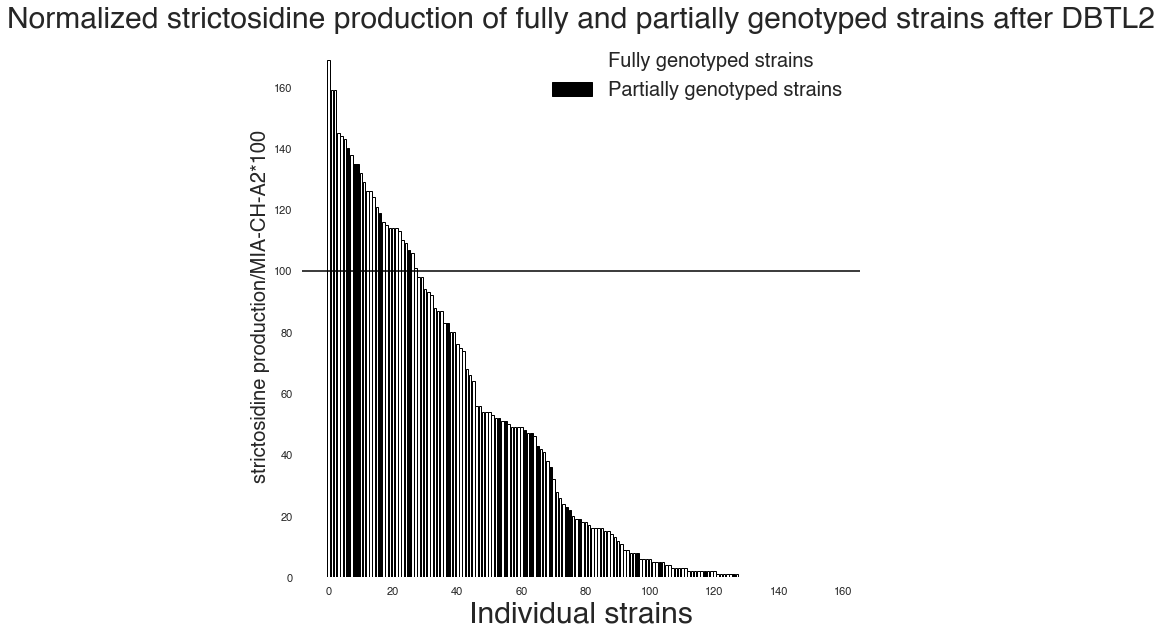

In [137]:
grouped_bar_plot(indexes, normalzed_strict, colors, category_labels = ['Fully genotyped strains','Partially genotyped strains' ],
                         title = 'Normalized strictosidine production of fully and partially genotyped strains after DBTL2',
                         y_label = 'strictosidine production/MIA-CH-A2*100' ,
                         x_label = 'Individual strains',
                         path = 'ConStrain_on_google_colab/data/10-plots/10_2_TEST_Library_characterization/', 
                        axhline = True, 
                        )

# 7. Carpet plot of top performing genotypes

In [138]:
input_for_ml = pd.read_csv('ConStrain_on_google_colab/data/09-AutoML/input_to_ml/second_round/input_for_ml_2nd_iteration_all_analytics.csv', index_col= False)

In [139]:
list_of_promoters = ["pCYC1", "pENO2","pPCK1","pRPL15B", "pCCW12", "pTPI1","pMLS1","pURE2"]
promoter_dict = {i+1:list_of_promoters[i]for i in range(len(list_of_promoters))}

In [140]:
g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]

pg8h_list_of_index = ['pCYC1', 'pENO2']
pcpr_list_of_index = ['pCCW12', 'pTPI1'] 

g8h_genotype = []
cpr_genotype = []
pg8h_genotype = []
pcpr_genotype = []

# adding index of genotypes to individual rows 
for index, row in input_for_ml.iterrows():
    # homologs
    g8h_name = g8h_list_of_index[int(row['0']-1)]
    cpr_name = cpr_list_of_index[int(row['3']-1)]
    
    # promoters
    pg8h_name =promoter_dict[row['1']]
    pcpr_name = promoter_dict[row['2']]
    
    
    # save the genotypes
    g8h_genotype.append(g8h_name)
    cpr_genotype.append(cpr_name)
    pg8h_genotype.append(pg8h_name)
    pcpr_genotype.append(pcpr_name)

    
input_for_ml['G8H'] = g8h_genotype
input_for_ml['CPR'] = cpr_genotype
input_for_ml['pG8H'] = pg8h_genotype
input_for_ml['pCPR'] = pcpr_genotype
    
len(input_for_ml)

129

In [141]:
for_plotting_input_for_ml = input_for_ml[['Line_name', 'G8H', 'pG8H','pCPR', 'CPR' ]]
for_plotting_input_for_ml.columns = ['Line_name', 'G8H', 'pG8H','pCPR', 'CPR']
for_plotting_input_for_ml

,Line_name,G8H,pG8H,pCPR,CPR
0,yp53_A01,VminG8H,pCYC1,pCCW12,AanCPR
1,yp53_A02,VminG8H,pCYC1,pCCW12,AanCPR
2,yp53_A04,VminG8H,pENO2,pCCW12,AanCPR
3,yp53_A06,SmusG8H,pCYC1,pCCW12,AanCPR
4,yp53_A07,SmusG8H,pENO2,pTPI1,AanCPR
...,...,...,...,...,...
124,yp54_A04,VminG8H,pCYC1,pTPI1,CroCPR
125,yp54_C04,SmusG8H,pENO2,pTPI1,AraCPR
126,yp54_C09,CroG8H,pCYC1,pTPI1,AraCPR
127,yp54_D12,SmusG8H,pCYC1,pTPI1,AhuCPR


In [142]:
# merge with the ones that are only partially genotyped: 
all_strains_w_wo_full_geno = pd.merge(for_plotting_input_for_ml,concated_genotypes, on=['Line_name'],  how='right' )
all_strains_w_wo_full_geno

,Line_name,G8H,pG8H,pCPR,CPR,index,Amt_norm,Genotyped
0,yp53_D09,SmusG8H,pENO2,pTPI1,RseCPR,38,169,Fully - (Promoters and enzyme homologs)
1,yp53_C06,RsepG8H,pENO2,pTPI1,CloCPR,26,159,Fully - (Promoters and enzyme homologs)
2,yp53_A07,SmusG8H,pENO2,pTPI1,AanCPR,4,159,Fully - (Promoters and enzyme homologs)
3,yp53_E02,RsepG8H,pENO2,pTPI1,RseCPR,42,145,Fully - (Promoters and enzyme homologs)
4,yp53_B02,CroG8H,pENO2,pTPI1,AanCPR,11,144,Fully - (Promoters and enzyme homologs)
...,...,...,...,...,...,...,...,...
153,yp54_G01,NaN,NaN,NaN,NaN,135,0,Partially - (only enzyme homologs)
154,yp54_F12,NaN,NaN,NaN,NaN,134,0,Partially - (only enzyme homologs)
155,yp54_G02,NaN,NaN,NaN,NaN,133,0,Partially - (only enzyme homologs)
156,yp53_A03,NaN,NaN,NaN,NaN,131,0,Partially - (only enzyme homologs)


In [143]:
list_of_parts = []
parst_index = []

for index, row in all_strains_w_wo_full_geno.iterrows():
    list_of_parts.append(row['G8H'])
    list_of_parts.append(row['pG8H'])
    list_of_parts.append(row['pCPR'])
    list_of_parts.append(row['CPR'])
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)
    parst_index.append(index)

distribution = [25]*len(parst_index)
print(len(list_of_parts))
print(len(parst_index))
print(len(distribution))

632
632
632


In [144]:
d = {'Index':parst_index,'Part':list_of_parts, 'Distribution':distribution }
df2 = pd.DataFrame(d)

In [145]:
df2 = df2.replace(np.nan, 'Not_fully_genotyped')

In [146]:
pd.set_option('display.max_columns', None)

In [147]:
cross_tab_prop = pd.crosstab(index=df2['Index'],
                             columns=df2['Part'])
cross_tab_prop

Part,AanCPR,AhuCPR,AniCPR,AraCPR,CloCPR,CroCPR,CroG8H,Not_fully_genotyped,OeuG8H,RseCPR,RsepG8H,SmusG8H,VminG8H,pCCW12,pCYC1,pENO2,pTPI1
Index,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1
1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1
2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1
4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0
154,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0
155,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0


In [148]:
coloumns = list(cross_tab_prop.columns)

Have to make a new colorDict since the names in this data is different

In [149]:
g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]
pg8h_list_of_index = ["pCYC1", "pENO2","pPCK1","pRPL15B"]
pcpr_list_of_index = ["pCCW12", "pTPI1","pMLS1","pURE2"]
NaN_list_of_index = ["Not_fully_genotyped"]

all_parts = g8h_list_of_index +cpr_list_of_index+ pg8h_list_of_index+pcpr_list_of_index+ NaN_list_of_index

In [150]:
from constrain.plotting.plotting import color_range_dict
# importing a range of colors
cpr_color = color_range_dict()['yellow'][::2][::-1]
print(len(cpr_color))
pcpr_color = color_range_dict()['orange'][::6][::-1]
print(len(pcpr_color))
g8h_color= color_range_dict()['blue'][::3][::-1]
print(len(g8h_color))
pg8h_color = color_range_dict()['green'][::5][::-1]
print(len(pg8h_color))

10
4
8
4


In [151]:
G8H_color_codes = dict(zip(g8h_list_of_index, g8h_color))
pG8H_color_codes = dict(zip(pg8h_list_of_index, pg8h_color))
pCPR_color_codes = dict(zip(pcpr_list_of_index, pcpr_color))
CPR_color_codes = dict(zip(cpr_list_of_index, cpr_color))

In [152]:
colorDict = dict(G8H_color_codes, **pG8H_color_codes,**pCPR_color_codes, **CPR_color_codes)
colorDict

{'CacuG8H': '#a6f3ff',
 'OpumG8H': '#95e2ff',
 'CroG8H': '#84d1ff',
 'VminG8H': '#73c2f8',
 'SmusG8H': '#63b3e8',
 'RsepG8H': '#52a5d9',
 'OeuG8H': '#4197ca',
 'CcalG8H': '#2d89bc',
 'pCYC1': '#78f8a2',
 'pENO2': '#5fe08b',
 'pPCK1': '#44c876',
 'pRPL15B': '#24b161',
 'pCCW12': '#ffc470',
 'pTPI1': '#ff9c4b',
 'pMLS1': '#eb7e2d',
 'pURE2': '#cd6511',
 'CroCPR': '#fff647',
 'AanCPR': '#fde938',
 'AraCPR': '#f2df2b',
 'CloCPR': '#e6d51b',
 'RseCPR': '#dbcb03',
 'AhuCPR': '#d0c100',
 'AniCPR': '#c5b700',
 'CacCPR': '#bbad00',
 'OeuCPR': '#b0a300',
 'CpoCPR': '#a59a00'}

Making the parts appear in the correct order 

In [153]:
right_order = ['CacuG8H',
 'OpumG8H',
 'CroG8H',
 'VminG8H',
 'SmusG8H',
 'RsepG8H',
 'OeuG8H',
 'CcalG8H',
 'pCYC1',
 'pENO2',
 'pPCK1',
 'pRPL15B',
 'pCCW12',
 'pTPI1',
 'pMLS1',
 'pURE2',    
 'CroCPR',
 'AanCPR',
 'AraCPR',
 'CloCPR',
 'RseCPR',
 'AhuCPR',
 'AniCPR',
 'CacCPR',
 'OeuCPR',
 'CpoCPR', 
 'Not_fully_genotyped']

In [154]:
fixed_columns = []
for name in right_order: 
    if name in coloumns: 
        fixed_columns.append(name)
cross_tab_prop = cross_tab_prop[fixed_columns]

Add a white color to the not_fully_genotype colorDict

In [155]:
colorDict['Not_fully_genotyped'] = '#FFFFFF'

In [156]:
from constrain.plotting.plotting import carpet_barplot
import matplotlib
carpet_barplot
import matplotlib as mpl
# seaborn changes the aestetics and the following command reverts it
matplotlib.rc_file_defaults()


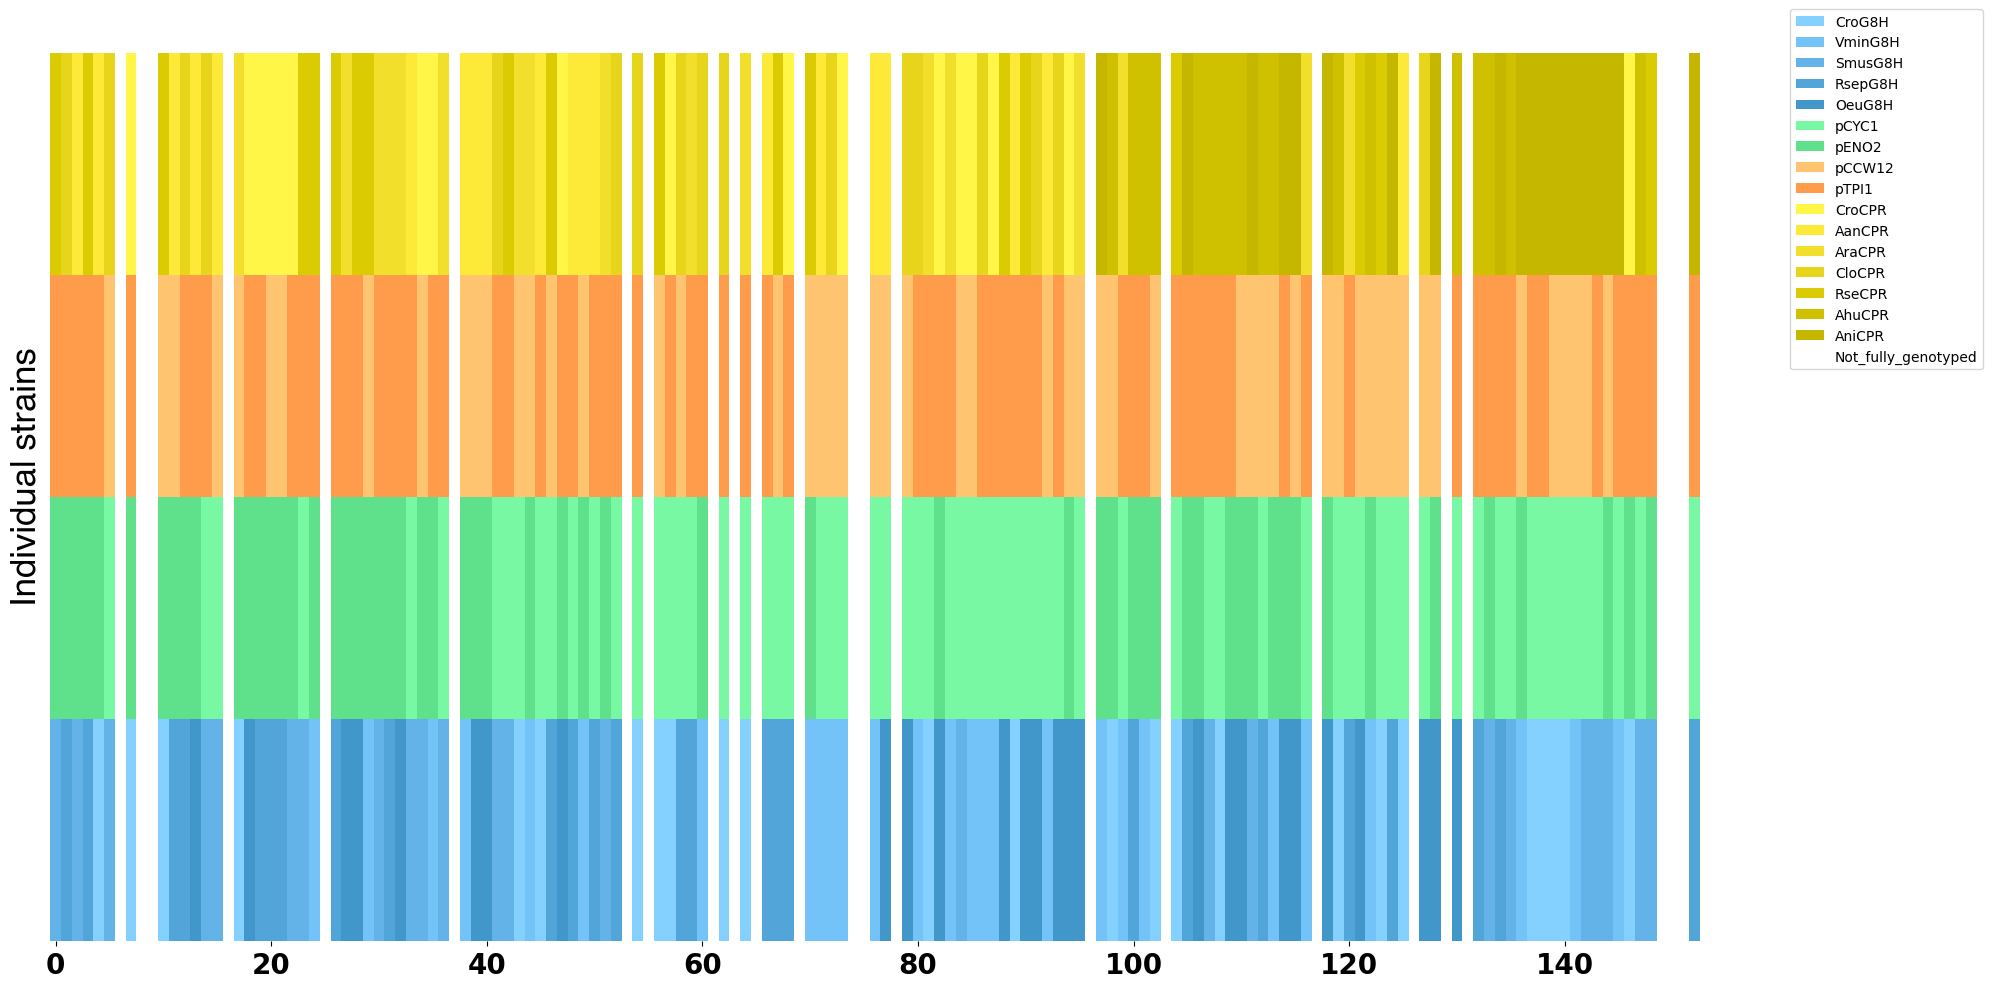

In [157]:
name = 'Carpet_plot_All_genotypes_from_the_SECOND_library_WHITE'
carpet_barplot(cross_tab_prop, colorDict, save_pdf= True , 
               path ='ConStrain_on_google_colab/data/10-plots/10_2_TEST_Library_characterization/'+name, 
               xlabel ='' , 
               ylabel = 'Individual strains' , 
               size_height = 10, 
               size_length = 20, 
               bar_width= 1.0
              )
